# RT Cooling and Heating

This notebook illustrates how to add cooling and heating by radiation transport (RT) to a prestellar core described by a Bonnor-Ebert sphere. The general idea is that the warm ISM that surrounds the BE-sphere is optically thick to UV-radiation, and can thus be kept at a constant temperature by being exposed to external radiation with that "radiation temperature".  The BE-sphere itself is very optically thick in UV-light, and is hence not affected much by the external UV, except in a thin boundary layer.

At the same time, the whole BE-sphere is optically transparent to infrared radiation.  As a simple example, we will use a warm ISM of 1000 L, with radiation field that peaks at about 3 $\mu$m, while the cold ISM, which is about 100 times cooler peaks instead at of the order of 300 $\mu$m.

In [1]:
import sys
import os

In [2]:
os.chdir('/Users/ChamillaTerp/Dropbox/Skole/Master/Computational Astrophysics/5-Radiation')
# Append the current working directory
sys.path.append(os.getcwd())

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# modules that are specific to the exercise
# see supporting files, if needed
from scaling     import scaling, CGS
from images      import imshow, imshows
from radiation   import Planck
from BE_sphere   import BE_sphere
from HD          import HD
from solvers     import MUSCL
from Riemann     import HLL
from selfgravity import FFT

# allow 40 figures to be opened
mpl.rcParams['figure.max_open_warning'] = 40

# stop the code if there are floating point errors
np.seterr(over = 'raise', invalid = 'raise', under = 'ignore');

## Estimates of UV and IR opacitiess

We can estimate the opacity at these very much lower temperatures by using the simple law of _dust extinction_, which states that the absorption by dust is roughly proportional to wavenumber (inverse wavelenght); cf. Fig 1 below.

<img src="./Interstellar_extinction.png" width="600"/>

Fig. 1: The visual extinction as a function of wavenumber (Credit: Karl D. Gordon - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1502191)

Fig. 1 shows that the extinction by dust is essentially linearly proportional to wavenumber, for wavelenghts longer than some 2500 Å or 0.25 $\mu$m. Therefore, we can conclude that the cold part of the ISM is shielded very efficiently from visual and UV light, while it is at the same time much more transparent to infrared light.

#### Relation between extinction and absorption in the visual

Extinction $A_V$ is measured in "magnitudes", with $A_V=1$ corresponding to about $1.8\,10^{21}$ H atoms per cm$^2$. $A_V$ is related to optical depth through the relation from the magnitude law relating intensity (really flux, but it scales the same way)

$$A_V = 2.5 \log_{10}(e)\tau_V $$

since we are counting hydrogen atoms, a good mean molecular weight is about 1.4. We can therefore find $\kappa_V$ in the optical as
$$ \kappa_V\,N_\textrm{col}\,\mu m_p = \int \kappa_V \rho dl = \tau_V = \frac{A_V}{2.5 \log_{10}(e)} = \frac{1}{2.5 \log_{10}(e)} \frac{N_\textrm{col}}{1.8\,10^{21} \textrm{ cm}^{-2}} $$

In [4]:
# notice how we use the scaling module to get unit mass (m_u) in CGS units
mu = 1.4 # molecular mass for atomic hydrogen
kappa_V = 1. / (2.5*np.log10(np.exp(1.))*1.8e21*mu*CGS.m_u)
print('The absorption in the visual is {:.1e} cm2/g.'.format(kappa_V))

The absorption in the visual is 2.2e+02 cm2/g.



#### Absorption at infrared wavelengths
At long wavelengths matter is much more transparent. That is why we use sub-mm and radio telescopes such as ALMA and VLA to observe star forming regions and pierce through dusty galaxies. The visual band has a weighted central wavelength of 540 nm. If there were a completely linear relation between extinction at different wavelengths, then the absorption at e.g.~1 mm would be $\kappa = 220\textrm{ cm}^2 \textrm{ g}^{-1}\,540\textrm{ nm }/\,1\textrm{ mm} = 0.12\textrm{ cm}^2 \textrm{ g}^{-1}$. In reality the relation is not completely linear and a typical value for $\kappa$ at a wavelength of 1 mm is $\kappa_{mm} = 1\textrm{ cm}^2 \textrm{ g}^{-1}$.

Computing opacities across a broad range of wavelengths is a herculean task, since the opacities depends on the microphysics. For contributions from the gas there is a dependency on the temperature and density and the chemistry and excitation / ionization state of the atoms and/or molecules. At large wavelength, the opacity is dominated by the dust, and the specific chemical composition and size distribution of the dust matters, as well as the fraction of heavier elements that are frozen out as refractory and icy dust.

A useful python based tool to generate custom dust opacity tables was developed during the DSHARP project, and can be found here: https://github.com/birnstiel/dsharp_opac.

An alternative to creating your own opacity table is to use one that has already been curated by others. For this exercise we will use an opacity table for dark clouds in the Milky Way created by Bruce Draine. See https://www.astro.princeton.edu/~draine/dust/dustmix.html

We cheat a bit by making it more steep than observed so that opacities are higher in the Optical / UV. This is useful, because our box is quite small, and therefore too transparent at short wavelengths. Also notice that the chosen opacity table depends on the subject at hand. E.g. in a protoplanetary dik the opacity is less steep because of larger grains, while in the Warm ISM it may different. One table does not work for all cases!

This opacity table has a steeper dependency on wavelength to facilitate the exercise.
Do not use it for research without removing the steepening, and consider if it is the right opacity foer your problem.
The absorption in the visual is 1.0e+06 cm2/g.


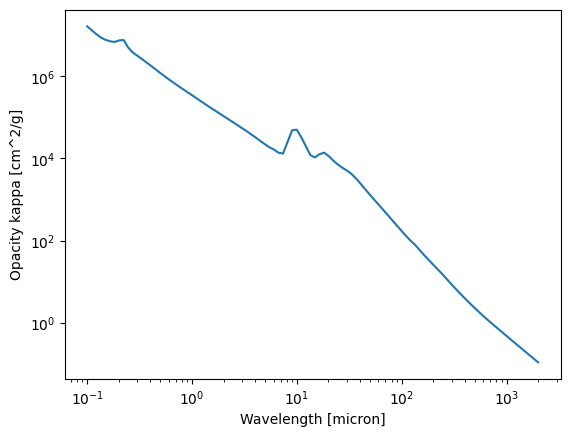

In [5]:
from urllib.request import urlopen
from scipy.interpolate import interp1d

class opacity():
    def __init__(self, units=None):
        # wavelength lambda is in micron
        # opacity kappa is in cm^2 / g (cgs)
        file = 'https://www.astro.princeton.edu/~draine/dust/extcurvs/kext_albedo_WD_MW_5.5A_30_D03.all'
        with urlopen(file) as f:
            while not f.readline().decode().startswith('--------'):
                pass
            lamb, kappa = np.loadtxt(f,usecols=(0,4)).T
        kappa = kappa * (lamb * 1e-4 / 0.2)**(-0.6)
        self.ln_kappa_cgs = interp1d(np.log(lamb*1e-4), np.log(kappa))
        if units != None:
            self.units = units
            ln_lamb_code = np.log(lamb*1e-4 / units.l)
            ln_kappa_code = np.log(kappa * units.m / units.l**2)
            self.ln_kappa_code = interp1d(ln_lamb_code, ln_kappa_code)
    def kappa_cgs(self,lamb): # assume lambda is in cgs units (cm)
        return np.exp(self.ln_kappa_cgs(np.log(lamb)))
    def kappa_code(self,lamb): # assume lambda is in code units
        return np.exp(self.ln_kappa_code(np.log(lamb)))

opac = opacity()

start = np.log10(1e-5) # First wavelength bin is at 0.1 micron = 1e-5 cm
stop = np.log10(0.2) # Last wavelength bin is at 1000 micron = 0.1 cm
waves = np.logspace(start, stop, num=100, endpoint=True)

plt.loglog(waves*1e4, opac.kappa_cgs(waves))
plt.xlabel('Wavelength [micron]')
plt.ylabel('Opacity kappa [cm^2/g]')
print('This opacity table has a steeper dependency on wavelength to facilitate the exercise.')
print('Do not use it for research without removing the steepening, and consider if it is the right opacity foer your problem.')
print('The absorption in the visual is {:.1e} cm2/g.'.format(opac.kappa_cgs(0.54*1e-4)))

### Expected equilibria

If there is an incoming radiation field with a radiation temperature of about 5000 K, the optically thin parts will settle to that temperature, while the optically thick parts will radiate from a surface located at a column density of about $0.005\textrm{ g cm}^{-2}$ in the visual since $\tau = \kappa \,N_\textrm{col}$.

The total surface density at the center of the BE-sphere may be estimated by taking a lenght $L=10^4$ AU, and a mass density of about $\rho = \frac{1 M_O}{L^3}$ giving $\Sigma_\textrm{col} = \rho\,L$. If we assume that the BE-sphere has a temperature of $T=10$ K then we can estimate the optical depth at the peak radiation intensity

In [6]:
sigma_col = (CGS.m_Sun/(1e4*CGS.AU)**3) * (1e4*CGS.AU)
print(sigma_col,"g / cm2")

0.08863620563956215 g / cm2


with a corresponding optical depth in visual and at the peak emmission of

In [7]:
tauV = opac.kappa_cgs(500e-7)*sigma_col # Visual band is at 500 nm
print('Visual optical depth estimate tau={:.2f}'.format(tauV))

peak_wavelength = 0.2898 / 10. # Wien's displacement law with constant in units of cm⋅K
tauIR = opac.kappa_cgs(peak_wavelength)*sigma_col
print('IR optical depth estimate tau={:.2f}'.format(tauIR))

Visual optical depth estimate tau=105824.13
IR optical depth estimate tau=0.84


It is thus reasonable to assume that the interior of the BE-sphere is optically thin to IR cooling, which implies an estimated cooling per unit volume and time (factor 4 comes from radiating in all directions instead of through a surface element, as is the case for an optically thick black-body)

\begin{equation}
q_{IR} = - 4\kappa\rho\sigma_{Stefan} T^4 \,,
\end{equation}

Blancing this, in nature the observed temperature of about 10 K is kept through by cosmic rays. We can conclude that the cosmic ray must be on the order of

\begin{equation}
q_{CR} \approx + 4\kappa\rho\sigma_{Stefan} (10 K)^4 \,,
\end{equation}

which tells us something about the cosmic-ray heating rate in observed clouds.

In our example the situation is slightly different though. We have far infrared radiation from the warm ISM that will give additional heating, even if the core is cooling in sub-mm and mm wavelengths, and therefore still a net heating. Other cooling agents that could be possible is CO line cooling. We will not explore that in this exercise, but you will try to add an effective cooling term to keep the center of the core at 10 K.

Note that this kind of "UV heating" is also seen in the real universe. Cores in the vicnity of the galactic center or closer to massive stars have in general higher temperatures, reaching 50 K. When the core heats up, the optical thin cooling increases, eventually balancing the heating from the surroundings.

## Setting up an Bonnor-Ebert sphere

We use the exact BE_sphere procedure from assignment `6a`; cf. the `BE_sphere.ipynb` notebook.  Note that `G` is not a free parameter, but has the value of the actual constant of nature -- scaled to code units !

First we use the HD class (from week 2) to setup a box. Then we use the BE_sphere procedure to fill the grid with reasonable variables

We define a set of units for our experiment by using the scaling package, and reload the opacities to get access to opacities in code units.

In [8]:
class BE_experiment(HD):
    def __init__(u, units, verbose=0, gamma=1.01, m_solar=1., **kwargs):
        HD.__init__(u,gamma=gamma,**kwargs)
        u.units = units
        BE_sphere(u, verbose=verbose, gamma=gamma, m_solar=m_solar)
        u.T = u.temperature()

units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, n=100, gamma=1.01);
opac = opacity(units=units)

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430968858477972, 'Stefan': 0.7666592511149339, 'h_P': 1.1119333906579644e-82, 'k_B': 6.941679235796882e-60, 'c': 299790.0, 'm_u': 8.409250879839114e-58}
BE_sphere: gamma,T_K= 1.01 10.0


We can try to plot a few variables to visualize the initial condition

See the Scaling.ipynb notebook for a discussion of the scaling to and from code units !

In [9]:
P = u.E*(u.gamma-1.0)*u.units.P
T = u.T*u.units.T
N = u.D*u.units.D/(u.units.mu*CGS.m_u)
P = P/CGS.k_B

plt.figure(figsize=(16,4))
m = u.n[0]//2
x = u.x*u.units.l/CGS.AU
plt.subplot(1,3,1); plt.semilogy(x,N[:,m,m],'-+'); plt.xlabel('AU'); plt.title('number density');        
plt.subplot(1,3,2); plt.semilogy(x,P[:,m,m],'-+'); plt.xlabel('AU'); plt.title('pressure [kT]');
plt.subplot(1,3,3); plt.semilogy(x,T[:,m,m],'-+'); plt.xlabel('AU'); plt.title('temperature [T]');

###  Generic RT solver class

This class contains routines for computing radiative transfer. It defines a basic set of variables describing the setup, a number of service functions, and the integral solver we used Tuesday.

In [10]:
class void(object):
    pass

class RT(object):
    """ basic RT properties """
    def __init__(self, n=32, direction=[0,], waves=[1], 
                 units=CGS, ds=1.):
        self.n       = (n,n,n)
        self.ds      = ds
        self.direction  = np.array(direction)
        self.weight  = 4.*np.pi / len(self.direction) # area per ray 
        self.units   = units
        self.waves   = np.array(waves) / units.l # assume wavelengths are input in CGS
        
        # calculate logarithmic distance between each wavelength point
        self.dlnwaves = 0.5 * (np.roll(np.log(self.waves),-1) - np.roll(np.log(self.waves),+1))
        self.dlnwaves[ 0] = np.log(self.waves[ 1]) - np.log(self.waves[ 0])
        self.dlnwaves[-1] = np.log(self.waves[-1]) - np.log(self.waves[-2])

        self.qtot    = np.zeros(self.n)
        self.opac    = opacity(units=units)
    
    def setup (self, D, T, iw=0):
        """ Compute values needed by the solver """
        self.opacity (D, T, iw)
        self.source_function (T, iw)
        self.optical_depths ()
    
    def transpose (self, axis, forward=True):
        """ Transpose values to be used in solver, so axis 
            becomes the new x-axis (when forward is true), 
            or is put back in place (when forward is false)
        """
        if axis==0:
            return
        # Move axis to first index
        if forward:
            if axis==1:
                t = [1,2,0]
            elif axis==2:
                t = [2,0,1]
            # Transpose rho*kappa, source function, and accumulated effective heating
            self.rkap   = np.transpose(self.rkap,t)
            self.source = np.transpose(self.source,t)
            self.qtot   = np.transpose(self.qtot,t)
            # recompute optical depths, since they are a running sum of rkap
            self.optical_depths()
            
        # Move first index to axis
        else:
            if axis==1:
                t = [2,0,1]
            elif axis==2:
                t = [1,2,0]
            # Transpose back rho*kappa, source function, and accumulated effective heating
            self.rkap   = np.transpose(self.rkap,t)
            self.source = np.transpose(self.source,t)
            self.qtot   = np.transpose(self.qtot,t)
            # recompute optical depths, since they are a running sum of rkap
            self.optical_depths()

    def opacity(self, D, T, iw=0):
        """ Absorption for one set of wavelengths """
        wave = self.waves[iw]
        self.rkap = D*self.opac.kappa_code(wave)

    def source_function(self, T, iw=0):
        """ Weighted source funtion for temperatures """
        self.source = Planck(T*self.units.T, self.waves[iw], units=self.units)

    def optical_depths (self):
        """ optical depth increment across one interval of size self.ds """
        self.dtau = np.zeros(self.n)
        for i in range(self.dtau.shape[0]-1):
            self.dtau[i] = self.optical_depth (self.rkap[i], self.rkap[i+1])

    def optical_depth (self, rk0, rk1):
        """ optical depth increment across one interval of size self.ds """
        return 0.5*self.ds*(rk0 + rk1)
    
    def radiation_solver (self, Left=None, Right=None, iw=None):
        """ integral solver from the Tuesday exercise """
        dtau = self.dtau
        S = self.source
        I = np.zeros_like(S) # intensity array
        Q = - np.copy(S)     # heating starting at "-S"

        # Forward solution, from the left to the right boundary
        if type(Left) != type(None):            
            I[0] = Left
        else:
            I[0] = 0.            

        for i in range(1,I.shape[0]):
            e1 = np.exp(-dtau[i-1])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i-1]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i-1] + e4*S[i-1] + e5*S[i]
        
        Q += 0.5*I # add heat from forward ray
        
        # Reverse solution, from the right to the left boundary
        if type(Right) != type(None):
            I[-1] = Right
        else:
            I[-1] = 0.

        for i in range(I.shape[0]-2,-1,-1):
            e1 = np.exp(-dtau[i])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i+1] + e4*S[i+1] + e5*S[i]
        
        Q += 0.5*I # add heat from reverse ray
        
        if iw != None:
            self.qtot += self.rkap*Q*self.dlnwaves[iw]*self.weight
        else:
            self.qtot += self.rkap*Q*self.weight
                
    def rt_step(self,u_HD):
    
        u_HD.T = (u_HD.pressure() / u_HD.D)
        
        self.qtot[:] = 0.
        
        for iw in range(len(self.waves)):
            self.setup(u_HD.D, u_HD.T, iw=iw)
            self.radiation_solver(iw=iw)

## Set up Bonnor-Ebert experiment with radiative transfer
The combination of the Bonnor Ebert sphere and the RT class allows us to set up an experiment by
  1. choose the units of the experiment
  2. define our Bonnor-Ebert initial condition
  3. set up the radiative transfer object with a number of wavelengths

In [11]:
units = scaling(l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment(units, m_solar=1., n=64, gamma=1.01);

# Use 8 wavelengths to get approximately 2 wavelengths per dex
start = np.log10(.5e-4) # First wavelength bin is at .5 micron
stop = np.log10(2000e-4) # Last wavelength bin is at 2000. micron
waves = np.logspace(start, stop, num=8, endpoint=True)

rt = RT(n=u.n[0],waves=waves,units=u.units,ds=u.ds,direction=[0,])

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430968858477972, 'Stefan': 0.7666592511149339, 'h_P': 1.1119333906579644e-82, 'k_B': 6.941679235796882e-60, 'c': 299790.0, 'm_u': 8.409250879839114e-58}
BE_sphere: gamma,T_K= 1.01 10.0


Having established temperatures and densities we can compute and plot the values used by the RT solver.  

The RT solver primarily needs `rkap` $= \rho\kappa(\rho,T)$ and `source` = $S(T)$, but has a `setup` method that takes `(D, T)` and computes `rkap` and `source` from these.

total UV-tau at edge: 349.49045532089525
total UV-tau through center: 108672.58621989831
total IR-tau through center: 0.009976216907790735


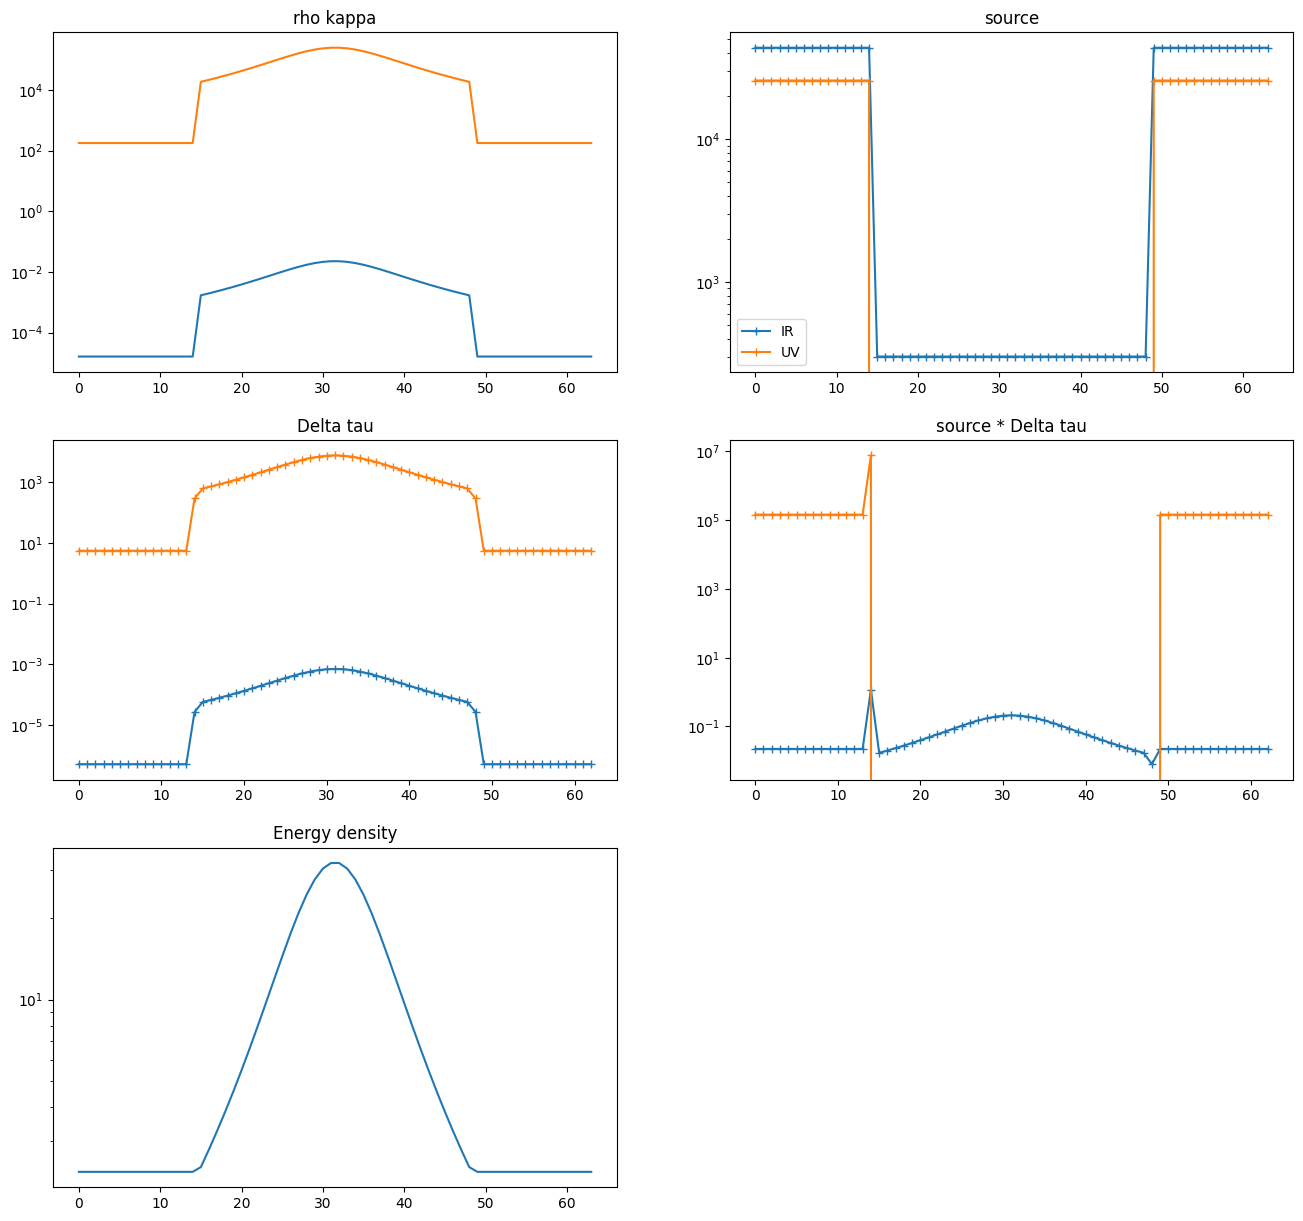

In [12]:
rt.setup(u.D, u.T, iw=0); s0 = rt.source; dtau0 = rt.dtau; rkap0 = rt.rkap
rt.setup(u.D, u.T, iw=-1); s1 = rt.source; dtau1 = rt.dtau; rkap1 = rt.rkap

m=u.n[0]//2 # midplane

plt.figure(figsize=(16,15))

plt.subplot(3,2,1); 
plt.semilogy(rkap1[:,m,m]); 
plt.semilogy(rkap0[:,m,m]); 
plt.title('rho kappa');

plt.subplot(3,2,2); 
plt.semilogy(s1[:,m,m],'-+',label='IR'); 
plt.semilogy(s0[:,m,m],'-+',label='UV'); 
#plt.ylim(1e2,1e17)
plt.title('source'); plt.legend();

plt.subplot(3,2,3); 
plt.semilogy(dtau1[:-1,m,m],'-+'); 
plt.semilogy(dtau0[:-1,m,m],'-+'); 
plt.title('Delta tau');

plt.subplot(3,2,4); 
plt.semilogy((s1*dtau1)[:-1,m,m],'-+'); 
plt.semilogy((s0*dtau0)[:-1,m,m],'-+'); 
plt.title('source * Delta tau');

plt.subplot(3,2,5); 
plt.semilogy(u.E[:,m,m]); 
plt.title('Energy density');

print('total UV-tau at edge:',np.sum(dtau0[:,0,0]))
print('total UV-tau through center:',np.sum(dtau0[:,m,m]))
print('total IR-tau through center:',np.sum(dtau1[:,m,m]))

### Images og cooling and heating
We can now compute the cooling and heating in different wave-bands and make slices through the center where we show images of the heating and cooling rates

NOTICE: min and max changes in each figure!


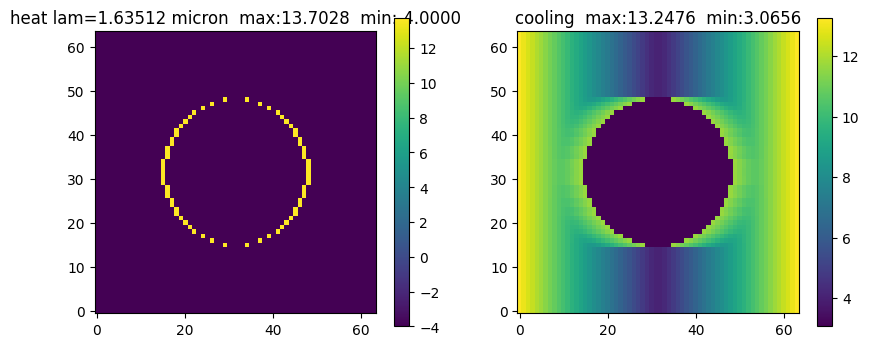

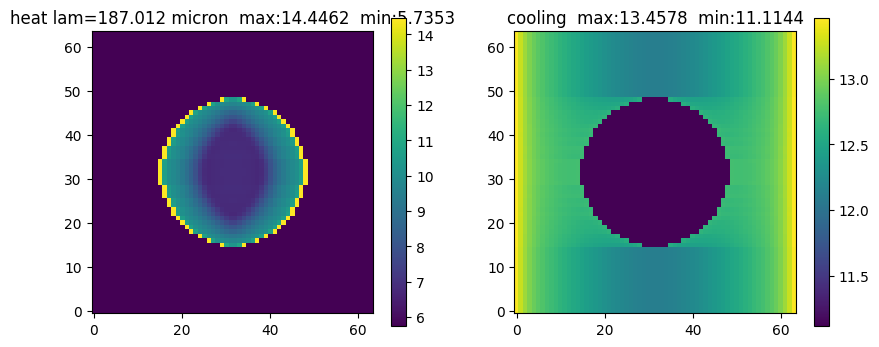

In [13]:
m = u.n[2]//2 # use index through center for slices
print("NOTICE: min and max changes in each figure!")
qtot = np.zeros(u.n) # store the cumulative heating / cooling rate in this variable

# loop over wavelengths
for iw in range(len(waves)):

    # compute source function, dtau etc
    rt.setup(u.D, u.T, iw=iw)
        
    # compute radiative transfer
    rt.radiation_solver(iw=iw)
    qtot += rt.qtot

    # select a plane through center of box
    plane = rt.qtot[:,:,m]
    
    # Heating
    
    # cut are the points that have a positive heating rate
    # use it to compute a reasonable floor value for the heating
    # use 1e-4 as an arbitrarily enforced minimum value
    cut = plane[plane>0.]
    if len(cut)==0:
        floor = 1.
    else:
        floor = (cut).min()*0.1
    floor = max(1e-4,floor)

    # make all points in the heating array equal to at least the floor value
    # this gives pixels where there iscooling or  very low heating the same colour
    heating = np.maximum(plane,floor)
    
    # Cooling. Use same procedure as for heating
    cut = -plane[-plane>0.]
    if len(cut)==0:
        floor = 1.
    else:
        floor = (cut).min()*0.1
    floor = max(1e-4, floor)
    cooling = np.maximum(-plane,floor)
    
    # We use log heating and cooling to extend the dynamical range (could also use power to the 0.1)
    imshows([np.log10(heating),np.log10(cooling)],title=np.array(['heat lam={:0.6} micron'.format(waves[iw]*1e4),'cooling']))
    plt.savefig('RT_{:02d}.png'.format(iw));


### Estimating effective opacity for the Prestellar core
Our pre-stellar core has an initial temperature of 10 K. We can try to estimate the effective opacity by computing the opacity weighted by the planck function . This is also called the Planck-mean opacity. Once it has been obtained we can try to calculate numerically what the optical thin cooling rate per mass would be and compare it with the analytical value to test that we have the right result.

In [14]:
Temp=10. # Temperature
kap = np.empty_like(rt.waves) # opacity at wavelength points
B = np.empty_like(rt.waves)   # Planck spectrum for T=10K at wavelength points

for i,w in enumerate(rt.waves):
    kap[i] = opac.kappa_code(w)
    B[i] = Planck(Temp,w,units=u.units)

kpl_10K = (kap * B * rt.dlnwaves).sum() / (B * rt.dlnwaves).sum()
print('Planck-mean absorption at 10 K [code units]:', kpl_10K)
print('Maximum optical depth at 10 K:', (u.D.sum(axis=0)*u.ds).max()*kpl_10K)
print('Ratio of numerical integrated to expected Planck intensity at 10 K:', \
        (np.pi*B*rt.dlnwaves).sum()/(u.units.Stefan * Temp**4))
plt.loglog(rt.waves * u.units.l*1e4, kap * B,marker='+', label='Kappa * Intensity [code units]')
mx = (kap * B).max()
plt.ylim(1e-6*mx, 2.*mx)
plt.xlabel('Wavelength [micron]')
plt.legend();

Planck-mean absorption at 10 K [code units]: 0.23683994767634214
Maximum optical depth at 10 K: 0.9729093890354553
Ratio of numerical integrated to expected Planck intensity at 10 K: 2.9073077241554235


#### Heating rates and time scales
To get a feel for how fast things are changing we can examine the heating rates both at the center of the box and at other places. This will give us information on the needed timestep. Specifically $t_{cool} = E / Q$ is a cooling time scale in any cell of the model. What we realise is that our setup is highly artificial, because we have a very warm gas so close to a very cold one, leading to enourmous heating and cooling rates.

In [15]:
central_q = qtot[m,m,m]
optical_thin_cooling = -4*kpl_10K*u.D[m,m,m]*u.units.Stefan*1e4
print('Values for center of box:')
print('-------------------------')
print('Heating rate [erg/cm^3/s]              :', central_q * u.units.E / u.units.t)
print('Optical thin heating rate [erg/cm^3/s] :', optical_thin_cooling * u.units.E / u.units.t)
print('Heating time [code time, yr] :', u.E[m,m,m] / central_q, u.E[m,m,m] / central_q*u.units.t/CGS.yr)
print('-------------------------')
print('Minimum cool/heat time in whole box [code time, yr] :', (u.E / np.abs(qtot)).min(), (u.E / np.abs(qtot)).min()*u.units.t/CGS.yr)

Values for center of box:
-------------------------
Heating rate [erg/cm^3/s]              : 5.159390321817067e-15
Optical thin heating rate [erg/cm^3/s] : -1.6654341952530918e-17
Heating time [code time, yr] : 1.5286489246791539e-06 0.14511508803354703
-------------------------
Minimum cool/heat time in whole box [code time, yr] : 1.3613365105571237e-15 1.2923207178799566e-10


### __Task 1: Describe Heating and Cooling for the BE sphere__ (20p)

You now have a setup where you can have different wavelengths, and compute the heating and cooling rates for the setup. The solver works by looping over a direction and the a wavelength (from UV to IR).  For each direction it (should) compute the radiation transport in first the forward and then the reverse direction, and add the contributions from the two wavelenghts into `rt.qtot`. Describe what is happening in terms of the heating and cooling.

### __Task 2: Repair the symmetry of the solutions__ (20p)

Amend the setup so that it respect the symmetry of the solution for a real BE-sphere. In addition, add proper boundary conditions for the two wavelength bands.

## HD with self gravity and radiation
Notice that I have added a delay factor to the heating and cooling rates. This is because with explicit addition of the heating and cooling terms and the strong gradient in temperature, we would have to wait for a long time for the hydro dynamics to respond to the change in thermal pressure. To make it do able in less than 1000 iterations I add the delay factor.
To reduce clutter I have moved all the hydro and selfgravity files out of the notebook and in to seperate routines. They are essential the same as in week 2, but now in three dimensions and with selfgravity added.

The main addition is that I have added the radiation related source terms in an operator split manner with the HD + self-gravity solver called in between. I have also made an additional limit on the timestep. The heating / cooling is only allowed to change the thermal energy by 25% in a timestep.

In [16]:
# Function that combines af HD solver with radiative transfer
def Step(u, rt, tend = None, Crad = 0.1, delay_factor = 1.):    
    # Add half a time step worth of heating / cooling from last timestep
    Qrad = rt.qtot
    u.E += Qrad*(0.5*u.dt)
    dtold = u.dt

    # limit timestep based on Qrad and a max 25% change in dt per step
    dtmax = Crad * np.min(u.E / (np.abs(Qrad)+1e-10))
    dtmax = min(dtold*1.25, dtmax)
    
    # Take a HD step
    u.solver.Step(u, tend = tend, dtmax = dtmax)
    
    # Add another half a time step worth of heating / cooling from last timestep
    # to make a full RT contribution before recomputing the radiative transfer
    u.E += (u.dt - 0.5*dtold)*rt.qtot
    qold = np.copy(rt.qtot)

    # Recompute the net heating / cooling rate
    rt.rt_step(u)
    rt.qtot *= delay_factor # adjust impact of radiative transfer
    
    # Correct half a time step worth of heating / cooling with new solution
    u.E += 0.5*u.dt*(rt.qtot - qold)

##### Setup the initial condition and compute $Q_{rad}$ and $dt$ for first timestep 

In [17]:
units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, m_solar=1., n=64, gamma=1.01);

# Use 8 wavelengths to get approximately 2 wavelengths per dex
start = np.log10(.5e-4) # First wavelength bin is at .5 micron
stop = np.log10(2000e-4) # Last wavelength bin is at 2000. micron
waves = np.logspace(start, stop, num=12, endpoint=True)

rt = RT(n=u.n[0],waves=waves,units=u.units,ds=u.ds,direction=[0,])
u.rt = rt

u.solver = MUSCL(u)

delay_factor = 3e-10
Crad = 0.1

# Initial net heating / cooling rate
rt.rt_step(u)
rt.qtot *= delay_factor                   # adjust impact of radiative transfer
u.dt = (u.E / np.abs(rt.qtot)).min()*Crad # estimate initial time step

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430968858477972, 'Stefan': 0.7666592511149339, 'h_P': 1.1119333906579644e-82, 'k_B': 6.941679235796882e-60, 'c': 299790.0, 'm_u': 8.409250879839114e-58}
BE_sphere: gamma,T_K= 1.01 10.0


Example of how to take 60 timesteps and plot the evolution (if executed several times, it will continue the evolution)

It, time [yr, code_units], Max/Min Temp:  10 5.3194314325066685 5.603513217954288e-05 993.826016616361 9.999987966295148
It, time [yr, code_units], Max/Min Temp:  20 38.506095031686314 0.00040562495300401207 919.4908682785359 9.999903661042477
It, time [yr, code_units], Max/Min Temp:  30 218.5605207462917 0.0023023264468467843 666.6470989250147 9.999377977717687
It, time [yr, code_units], Max/Min Temp:  40 405.38595027864903 0.004270354002267745 561.1873713959315 9.998553520869404
It, time [yr, code_units], Max/Min Temp:  50 794.1453165424499 0.008365562813778277 459.0797088560904 9.99345588121058
It, time [yr, code_units], Max/Min Temp:  60 1348.7913458713701 0.014208229264252484 389.8753371477861 9.980220732990377


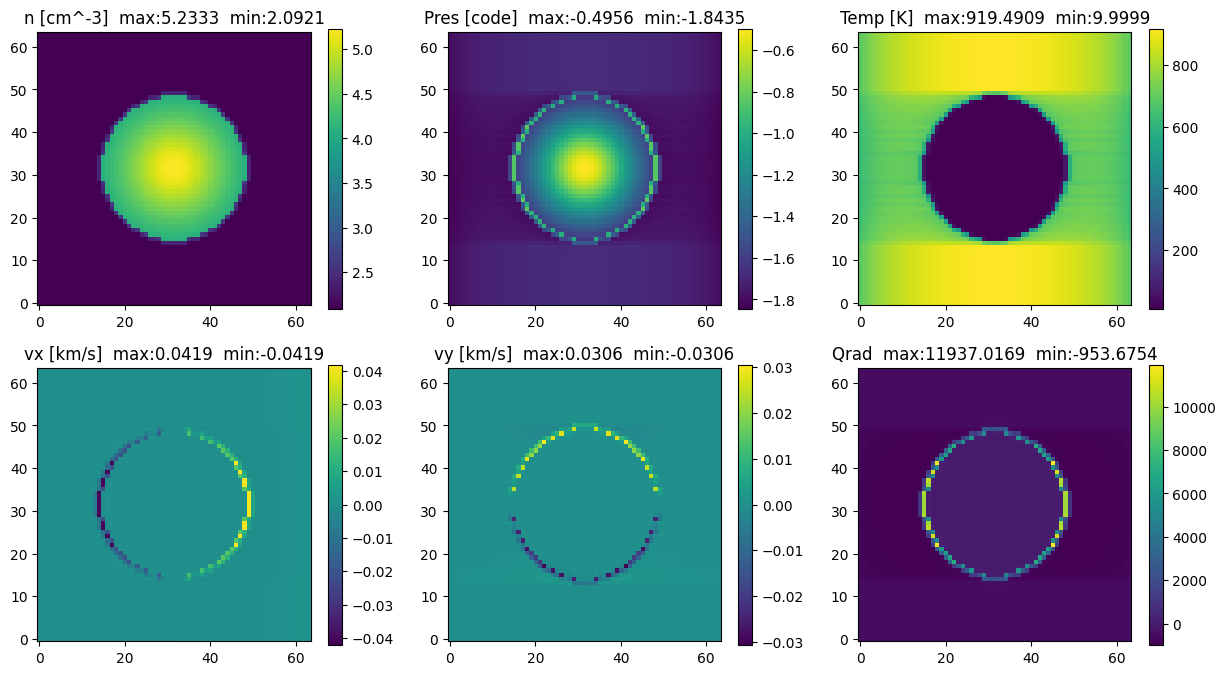

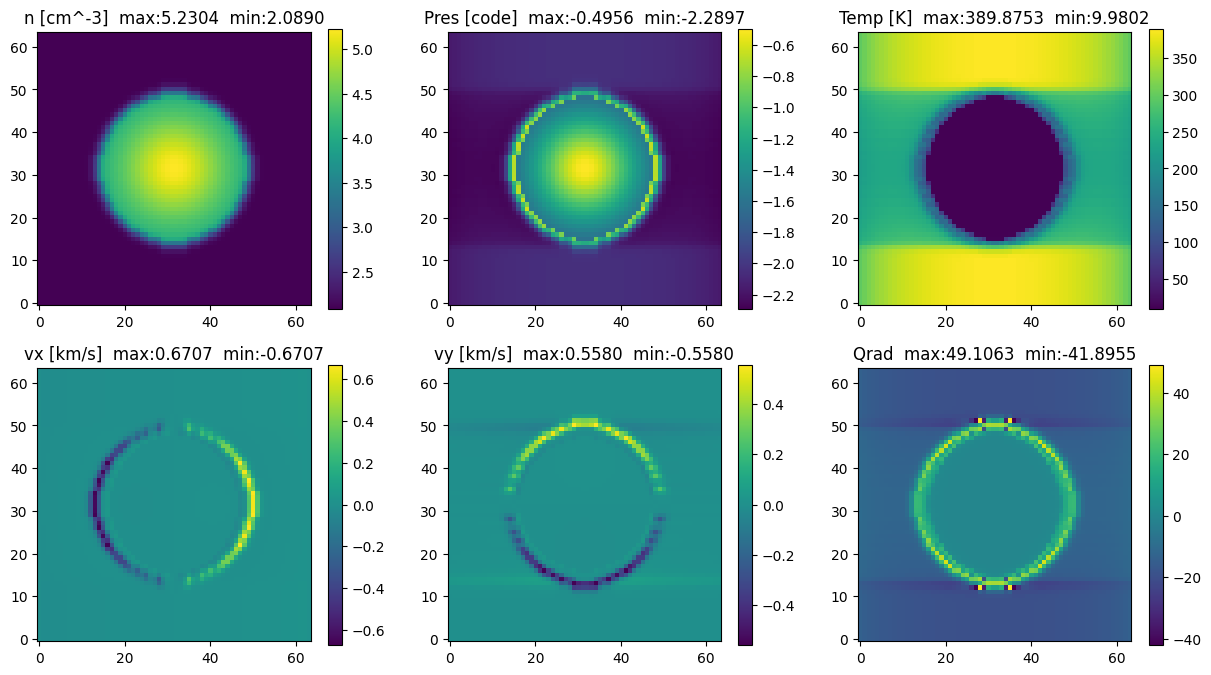

In [18]:
m = u.n[2]//2 # midplane

for i in range(60):
    Step(u, rt, Crad=Crad, delay_factor=delay_factor)
    u.T = (u.pressure() / u.D) * u.units.T
    
    if u.it % 10 == 0:
        print("It, time [yr, code_units], Max/Min Temp: ", \
              u.it, u.t * u.units.t / CGS.yr, u.t, u.T.max(), u.T.min())
    if u.it % 20 == 0:
        dens = np.log10(u.D[:,:,m]*u.units.D / (CGS.mu*CGS.m_u))
        vx = (u.velocity())[0,:,:,m]*u.units.v/CGS.kms
        vy = (u.velocity())[1,:,:,m]*u.units.v/CGS.kms
        pres = np.log10(u.pressure()[:,:,m])
        temp = u.T[:,:,m]
        imshows([dens,pres,temp,vx,vy,rt.qtot[:,:,m]],
                   title=np.array(['n [cm^-3]','Pres [code]','Temp [K]','vx [km/s]','vy [km/s]','Qrad']));

### Radial plots
Use ```u.r``` for the radial distance from the center (see ```HD.py```) and make plots of radial velocity, pressure, temperature, and density

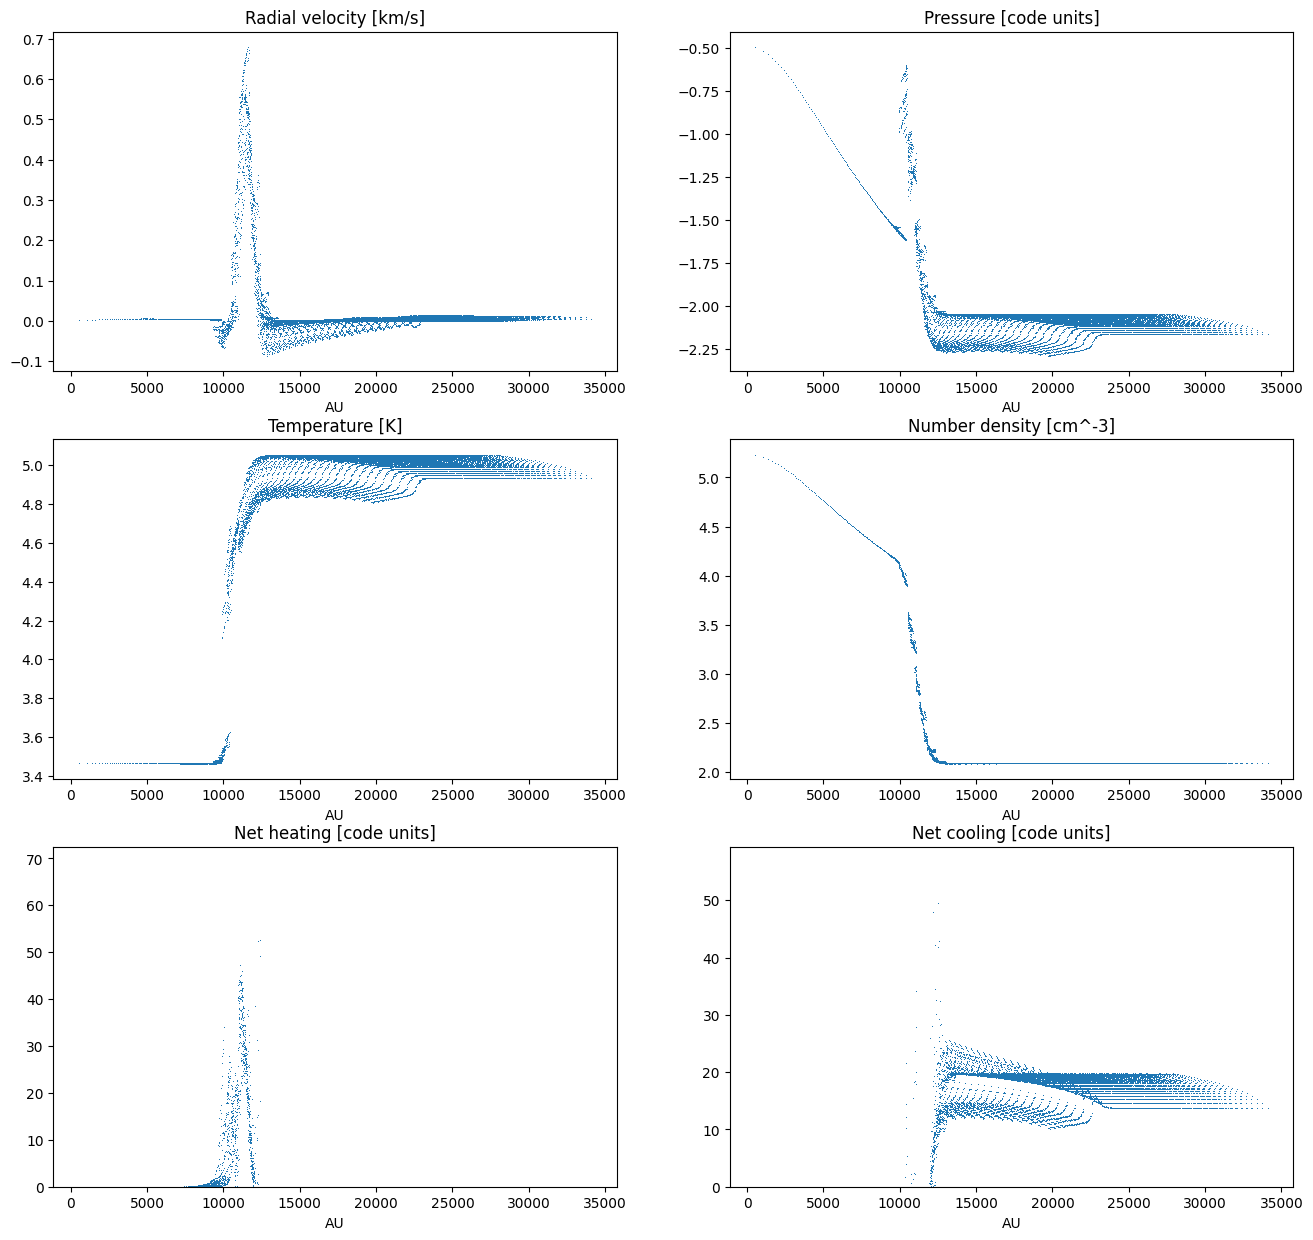

In [19]:
rr = np.copy(u.r)
vr = np.sum(u.velocity()*u.coords,axis=0) / rr * u.units.v / CGS.kms
rr *= u.units.l / CGS.AU

msize = 0.3

plt.figure(figsize=(16,15))
plt.subplot(3,2,1); plt.scatter(rr, vr, linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Radial velocity [km/s]');        

plt.subplot(3,2,2); plt.scatter(rr, np.log10(np.maximum(u.pressure(),1e-10)), linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Pressure [code units]');

plt.subplot(3,2,3); plt.scatter(rr, np.log10(np.maximum(u.T*u.units.T,0.01)),linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Temperature [K]');

plt.subplot(3,2,4); plt.scatter(rr, np.log10(u.D*u.units.D/(CGS.mu*CGS.m_u)),linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Number density [cm^-3]');

plt.subplot(3,2,5); plt.scatter(rr, rt.qtot,linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Net heating [code units]'); plt.ylim(0.,rt.qtot.max());

plt.subplot(3,2,6); plt.scatter(rr, -rt.qtot,linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Net cooling [code units]'); plt.ylim(0.,-rt.qtot.min());

### __Task 3: Setup a full experiment and discuss the results; include "cosmic ray cooling"__ (40p)

Once the radiative transfer is working, you can take the next step and couple it to Hydro dynamics. You should be able to see things changing in different ways as the experiment evolves. Some of the things you will notice are

   * The very sharp discontinuity at the edge of the core is changing.
   * The temperature is changing close to the pre-stellar core, and so does the velocities.
   * The temperature at the center should stay at 10 K, but it can only do that if the heating in far infrared and the cooling in the radio is compensated for by a corresponding cooling (negative heating term), which in reality comes mainly from cosmic rays and CO line cooling.
   
__Task 3a__ (30p): Run it for at least 400 iterations, but for as long as you like -- or as long as it works, and describe what is happening. What do you think is the physics driving the dynamics, and why does the setup evolve as it does?

__Task 3b__ (10p): Add an artificial term based on the numerical heating rate inspired by the notes above, so that the central temperature is kept at 10 K. It should be analogue to a cosmic ray heating. It may be difficult to see the heating at the centre in the plots or images, because of the large cooling and heating at the edge, but you can measure it.

#### __Absalon turn-in:__

Please answer the tasks by adding the code below this cell and copying your answers and supporting material to a seperate pdf, and upload it together with the notebook and corresponding pdf of the notebook. If you implement code as part of the tasks, please remember to describe what and why you have done it in the text.
___________________________________________

#### __Task 1 - Solution__
See the pdf "Cooling and heating" for solution.

#### __Task 2 - Solution__

In [20]:
class void(object):
    pass

class RT(object):
    """ basic RT properties """
    def __init__(self, n = 32, direction = [0,], waves = [1], 
                 units = CGS, ds = 1.):
        self.n       = (n,n,n)
        self.ds      = ds
        self.direction  = np.array(direction)
        self.weight  = 4.*np.pi / len(self.direction)       # Area per ray 
        self.units   = units
        self.waves   = np.array(waves) / units.l            # Assume wavelengths are input in CGS
        
        # Calculate logarithmic distance between each wavelength point
        self.dlnwaves = 0.5 * (np.roll(np.log(self.waves),-1) - np.roll(np.log(self.waves),+1))
        self.dlnwaves[ 0] = np.log(self.waves[ 1]) - np.log(self.waves[ 0])
        self.dlnwaves[-1] = np.log(self.waves[-1]) - np.log(self.waves[-2])

        self.qtot    = np.zeros(self.n)
        self.opac    = opacity(units=units)
    
    def setup (self, D, T, iw=0):
        """ Compute values needed by the solver """
        self.opacity (D, T, iw)
        self.source_function (T, iw)
        self.optical_depths ()
    
    def transpose (self, axis, forward=True):
        """ Transpose values to be used in solver, so axis 
            becomes the new x-axis (when forward is true), 
            or is put back in place (when forward is false)
        """
        if axis==0:
            return
        # Move axis to first index
        if forward:
            if axis==1:
                t = [1,2,0]
            elif axis==2:
                t = [2,0,1]
            # Transpose rho*kappa, source function, and accumulated effective heating
            self.rkap   = np.transpose(self.rkap,t)
            self.source = np.transpose(self.source,t)
            self.qtot   = np.transpose(self.qtot,t)
            # Recompute optical depths, since they are a running sum of rkap
            self.optical_depths()
            
        # Move first index to axis
        else:
            if axis==1:
                t = [2,0,1]
            elif axis==2:
                t = [1,2,0]
            # Transpose back rho*kappa, source function, and accumulated effective heating
            self.rkap   = np.transpose(self.rkap,t)
            self.source = np.transpose(self.source,t)
            self.qtot   = np.transpose(self.qtot,t)
            # Recompute optical depths, since they are a running sum of rkap
            self.optical_depths()

    def opacity(self, D, T, iw=0):
        """ Absorption for one set of wavelengths """
        wave = self.waves[iw]
        self.rkap = D*self.opac.kappa_code(wave)

    def source_function(self, T, iw=0):
        """ Weighted source funtion for temperatures """
        self.source = Planck(T*self.units.T, self.waves[iw], units=self.units)

    def optical_depths (self):
        """ optical depth increment across one interval of size self.ds """
        self.dtau = np.zeros(self.n)
        for i in range(self.dtau.shape[0]-1):
            self.dtau[i] = self.optical_depth (self.rkap[i], self.rkap[i+1])

    def optical_depth (self, rk0, rk1):
        """ optical depth increment across one interval of size self.ds """
        return 0.5*self.ds*(rk0 + rk1)
    
    def radiation_solver (self, Left=None, Right=None, iw=None):
        """ integral solver from the Tuesday exercise """
        dtau = self.dtau
        S = self.source
        I = np.zeros_like(S)                                        # Intensity array
        Q = - np.copy(S)                                            # Heating starting at "-S"

        # Forward solution, from the left to the right boundary
        if type(Left) != type(None):            
            I[0] = Left 
        else:
            I[0] = 0         

        for i in range(1,I.shape[0]):
            e1 = np.exp(-dtau[i-1])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i-1]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i-1] + e4*S[i-1] + e5*S[i]
        
        Q += 0.5*I                                                  # Add heat from forward ray
        
        # Reverse solution, from the right to the left boundary
        if type(Right) != type(None):
            I[-1] = Right
        else:
            I[-1] = 0

        for i in range(I.shape[0]-2,-1,-1):
            e1 = np.exp(-dtau[i])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i+1] + e4*S[i+1] + e5*S[i]
        
        Q += 0.5*I                                                  # Add heat from reverse ray
        
        if iw != None:
            self.qtot += self.rkap*Q*self.dlnwaves[iw]*self.weight
        else:
            self.qtot += self.rkap*Q*self.weight
                
    def rt_step(self,u_HD):
    
        u_HD.T = (u_HD.pressure() / u_HD.D)
        
        self.qtot[:] = 0.                                           # Reset heating array
        
        for iw in range(len(self.waves)):
            directions = [0, 1, 2]
            for idir in directions:
                self.setup(u_HD.D, u_HD.T, iw=iw)
            
                Left = (1-np.exp(-np.sum(rt.dtau[0,0,:]*0.1)))*rt.source[0]                 # Left boundary
                Right = (1-np.exp(-np.sum(rt.dtau[0,0,:]*0.1)))*rt.source[-1]               # Right boundary      

                RT.transpose(rt, axis = idir, forward = True)
            
                self.radiation_solver(Left = Left, Right = Right, iw = iw)

                RT.transpose(rt, axis = idir, forward = False)                              # Transpose back to original orientation

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430968858477972, 'Stefan': 0.7666592511149339, 'h_P': 1.1119333906579644e-82, 'k_B': 6.941679235796882e-60, 'c': 299790.0, 'm_u': 8.409250879839114e-58}
BE_sphere: gamma,T_K= 1.01 10.0
NOTICE: min and max changes in each figure!


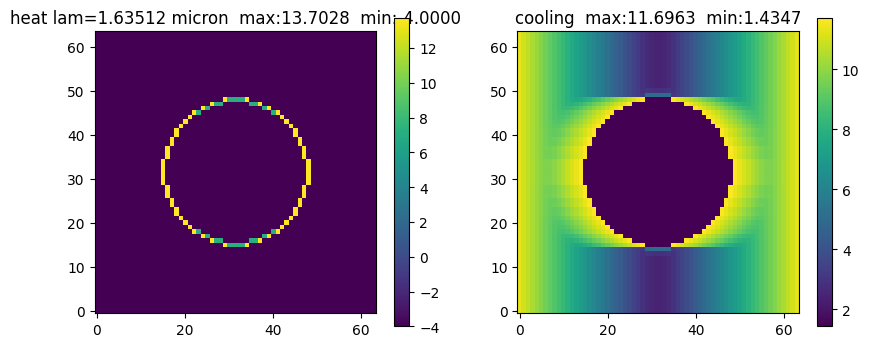

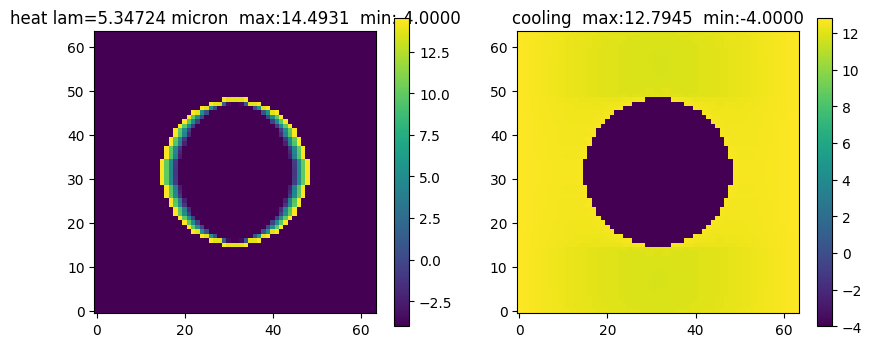

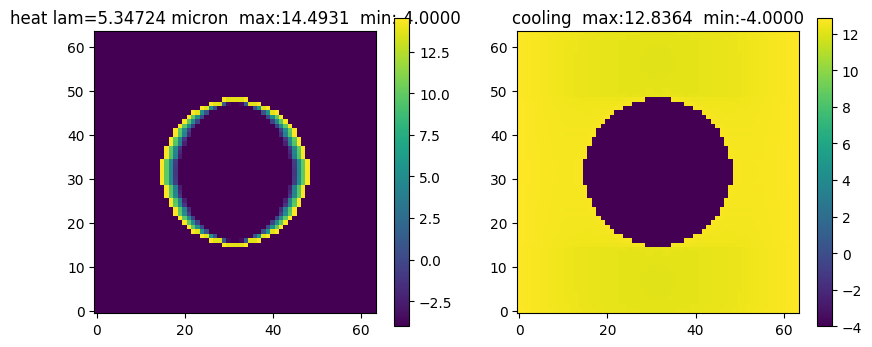

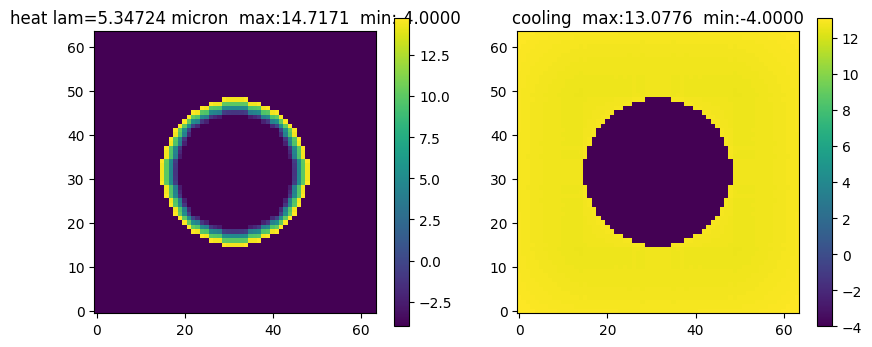

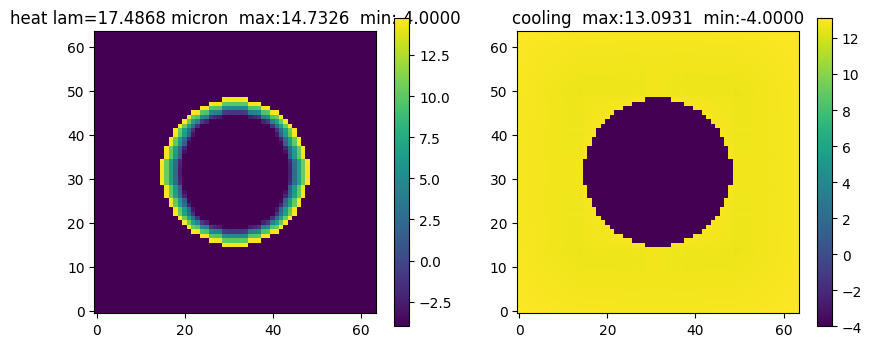

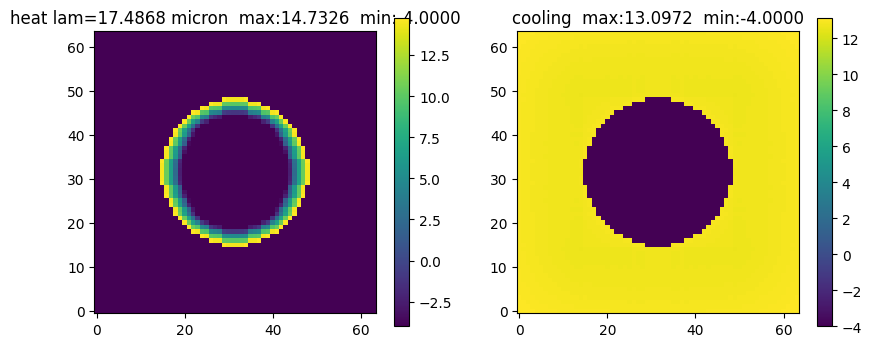

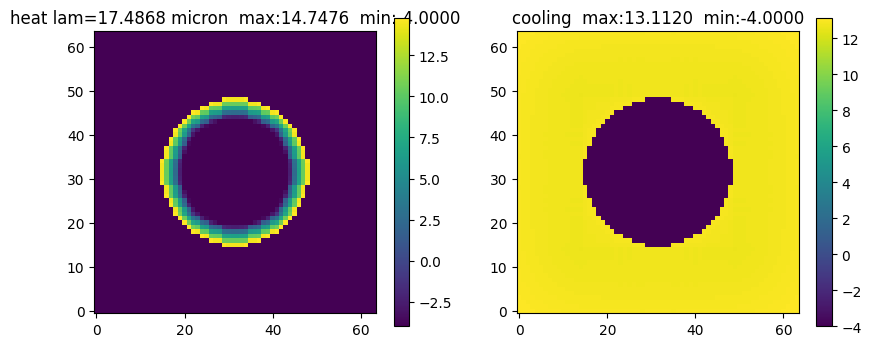

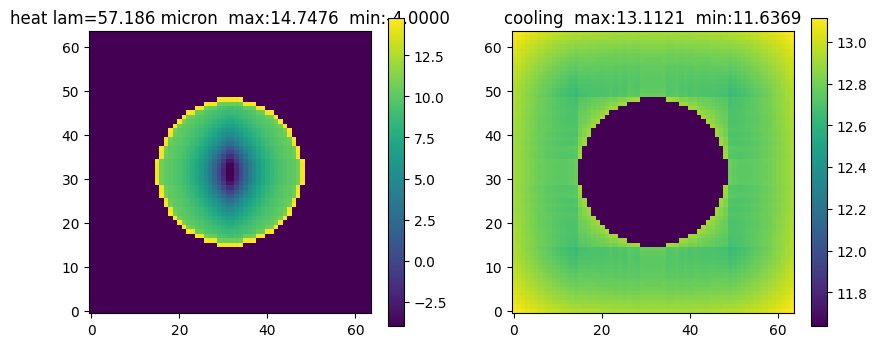

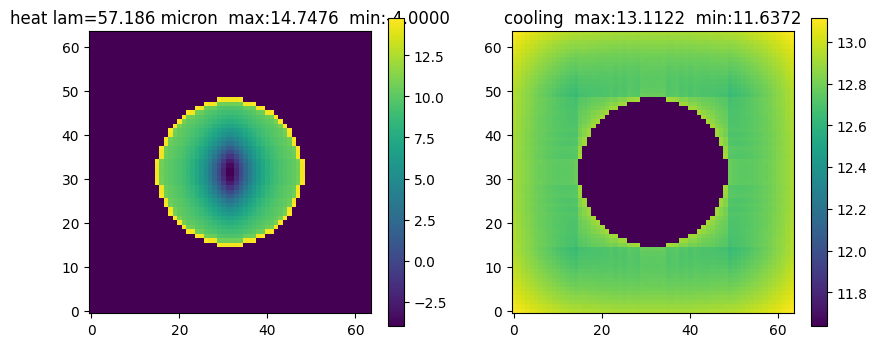

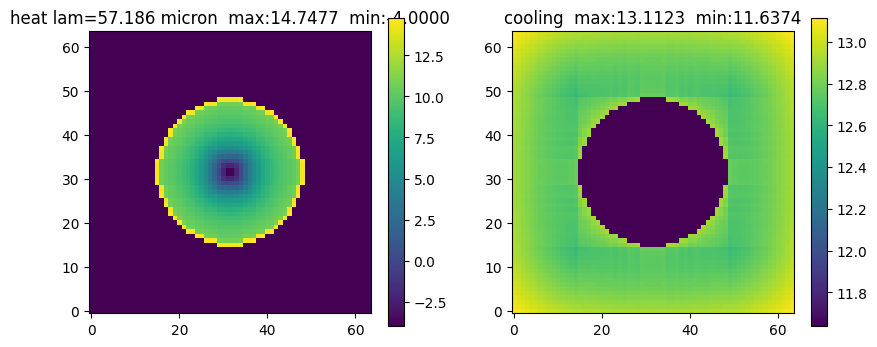

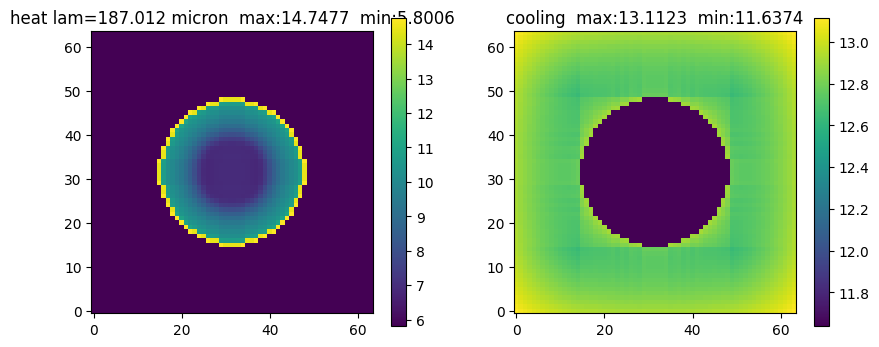

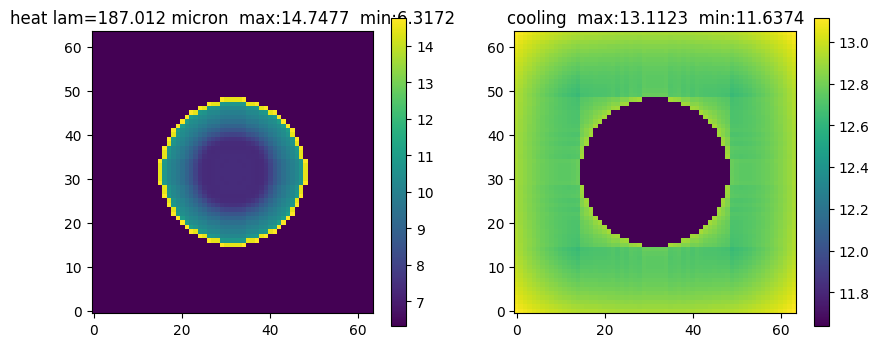

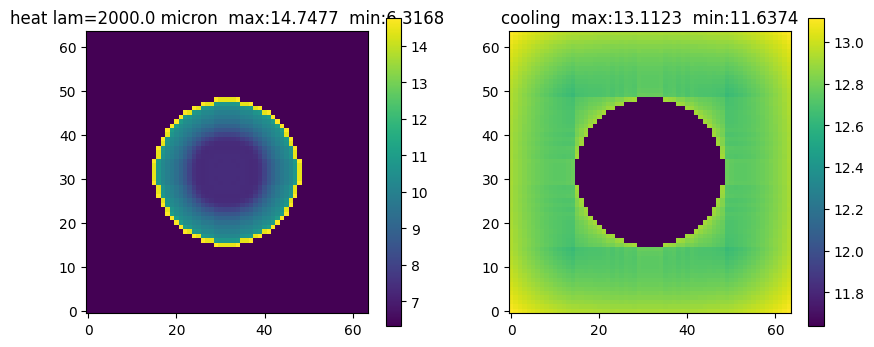

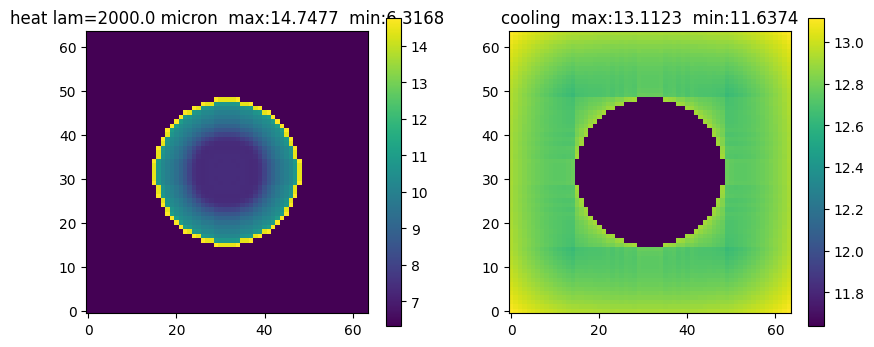

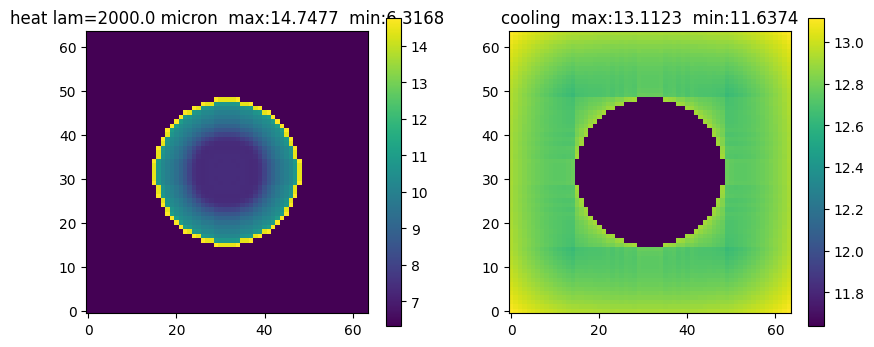

In [21]:
units = scaling(l = 2e4*CGS.AU, v = CGS.kms, m = CGS.m_Sun, verbose = 2);
u = BE_experiment(units, m_solar = 1., n = 64, gamma = 1.01);

# Use 8 wavelengths to get approximately 2 wavelengths per dex
start = np.log10(0.5e-4)                                                # First wavelength bin is at .5 micron
stop = np.log10(2000e-4)                                                # Last wavelength bin is at 2000. micron
waves = np.logspace(start, stop, num = 8, endpoint = True)

rt = RT(n = u.n[0], waves = waves, units = u.units, ds = u.ds, direction = [0,])

m = u.n[2]//2 # Use index through center for slices
print("NOTICE: min and max changes in each figure!")
qtot = np.zeros(u.n) # store the cumulative heating / cooling rate in this variable

# Loop over wavelengths
for iw in range(len(waves)):
    directions = [0, 1, 2]
    for idir in directions:

        # Compute source function, dtau etc
        rt.setup(u.D, u.T, iw = iw)
        
        # Setting up the boundary conditions
        Left = (1-np.exp(-np.sum(rt.dtau[0,0,:]*0.1))) * rt.source[0]       # 10% of the radiation is absorbed at the left boundary
        Right = (1-np.exp(-np.sum(rt.dtau[0,0,:]*0.1))) * rt.source[-1]     # 10% of the radiation is absorbed at the right boundary
            
        # Compute radiative transfer
        RT.transpose(rt, axis = idir, forward = True)                       # Transpose to make the direction the x-axis (forward)
        rt.radiation_solver(Left = Left, Right = Right, iw = iw)
        qtot += rt.qtot

        # Select a plane through center of box
        plane = rt.qtot[:,:,m]
        
        # ---- Heating ----
        
        # cut are the points that have a positive heating rate
        # use it to compute a reasonable floor value for the heating
        # use 1e-4 as an arbitrarily enforced minimum value
        cut = plane[plane>0.]
        if len(cut)==0:
            floor = 1.
        else:
            floor = (cut).min()*0.1
        floor = max(1e-4,floor)

        # make all points in the heating array equal to at least the floor value
        # this gives pixels where there iscooling or  very low heating the same colour
        heating = np.maximum(plane,floor)
        
        # Cooling. Use same procedure as for heating
        cut = -plane[-plane>0.]
        if len(cut)==0:
            floor = 1.
        else:
            floor = (cut).min()*0.1
        floor = max(1e-4, floor)
        cooling = np.maximum(-plane,floor)
        RT.transpose(rt, axis = idir, forward = False)              # Transpose back to original axis (backward)
        
        # We use log heating and cooling to extend the dynamical range (could also use power to the 0.1)
        imshows([np.log10(heating),np.log10(cooling)],title=np.array(['heat lam={:0.6} micron'.format(waves[iw]*1e4),'cooling']))
        plt.savefig('RT2_{:02d}.png'.format(iw));


In [22]:
Temp = 10. # Temperature
kap = np.empty_like(rt.waves) # opacity at wavelength points
B = np.empty_like(rt.waves)   # Planck spectrum for T=10K at wavelength points

for i,w in enumerate(rt.waves):
    kap[i] = opac.kappa_code(w)
    B[i] = Planck(Temp,w,units=u.units)

kpl_10K = (kap * B * rt.dlnwaves).sum() / (B * rt.dlnwaves).sum()
print('Planck-mean absorption at 10 K [code units]:', kpl_10K)
print('Maximum optical depth at 10 K:', (u.D.sum(axis=0)*u.ds).max()*kpl_10K)
print('Ratio of numerical integrated to expected Planck intensity at 10 K:', \
        (np.pi*B*rt.dlnwaves).sum()/(u.units.Stefan * Temp**4))
plt.loglog(rt.waves * u.units.l*1e4, kap * B,marker='+', label='Kappa * Intensity [code units]')
mx = (kap * B).max()
plt.ylim(1e-6*mx, 2.*mx)
plt.xlabel('Wavelength [micron]')
plt.legend();

Planck-mean absorption at 10 K [code units]: 0.23683994767634214
Maximum optical depth at 10 K: 0.9729093890354553
Ratio of numerical integrated to expected Planck intensity at 10 K: 2.9073077241554235


In [23]:
central_q = qtot[m,m,m]
optical_thin_cooling = -4*kpl_10K*u.D[m,m,m]*u.units.Stefan*1e4
print('Values for center of box:')
print('-------------------------')
print('Heating rate [erg/cm^3/s]              :', central_q * u.units.E / u.units.t)
print('Optical thin heating rate [erg/cm^3/s] :', optical_thin_cooling * u.units.E / u.units.t)
print('Heating time [code time, yr] :', u.E[m,m,m] / central_q, u.E[m,m,m] / central_q*u.units.t/CGS.yr)
print('-------------------------')
print('Minimum cool/heat time in whole box [code time, yr] :', (u.E / np.abs(qtot)).min(), (u.E / np.abs(qtot)).min()*u.units.t/CGS.yr)

Values for center of box:
-------------------------
Heating rate [erg/cm^3/s]              : 4.7863276107937447e-14
Optical thin heating rate [erg/cm^3/s] : -1.6654341952530918e-17
Heating time [code time, yr] : 1.6477970395632326e-07 0.015642585331214973
-------------------------
Minimum cool/heat time in whole box [code time, yr] : 1.6002037899308869e-16 1.5190781225072678e-11


#### __Task 3 - Solution__
##### __Task 3a__

In [24]:
units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, m_solar=1., n=128, gamma=1.01);

# Use 8 wavelengths to get approximately 2 wavelengths per dex
start = np.log10(.5e-4) # First wavelength bin is at .5 micron
stop = np.log10(2000e-4) # Last wavelength bin is at 2000. micron
waves = np.logspace(start, stop, num = 12, endpoint = True)

rt = RT(n=u.n[0],waves=waves,units=u.units,ds=u.ds,direction=[0,])
u.rt = rt

u.solver = MUSCL(u)

delay_factor = 3e-10
Crad = 0.1
# Initial net heating / cooling rate
rt.rt_step(u)
rt.qtot *= delay_factor                     # Adjust impact of radiative transfer
u.dt = (u.E / np.abs(rt.qtot)).min()*Crad   # Estimate initial time step

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430968858477972, 'Stefan': 0.7666592511149339, 'h_P': 1.1119333906579644e-82, 'k_B': 6.941679235796882e-60, 'c': 299790.0, 'm_u': 8.409250879839114e-58}
BE_sphere: gamma,T_K= 1.01 10.0


It, time [yr, code_units], Max/Min Temp:  50 156.03718698761804 0.0016437028108575518 558.5727098443676 10.000038157958592
It, time [yr, code_units], Max/Min Temp:  100 1514.2696116070722 0.015951384827209345 325.7696860106784 9.999557747996993
It, time [yr, code_units], Max/Min Temp:  150 7485.605455774847 0.07885370767164691 266.87924965768315 6.499371600778084
It, time [yr, code_units], Max/Min Temp:  200 13968.329608404089 0.1471430181713061 262.4656227756642 4.297914002709568
It, time [yr, code_units], Max/Min Temp:  250 20279.384430096015 0.21362395614613824 257.6514363403841 3.2072754436447717
It, time [yr, code_units], Max/Min Temp:  300 27392.42482508156 0.28855304655526504 241.81172357117535 2.519017027684499
It, time [yr, code_units], Max/Min Temp:  350 35743.53442787353 0.37652401420016307 231.0750462267209 2.05840391845145
It, time [yr, code_units], Max/Min Temp:  400 46374.88174643965 0.4885151094518142 214.53001544352622 1.7265001851496602


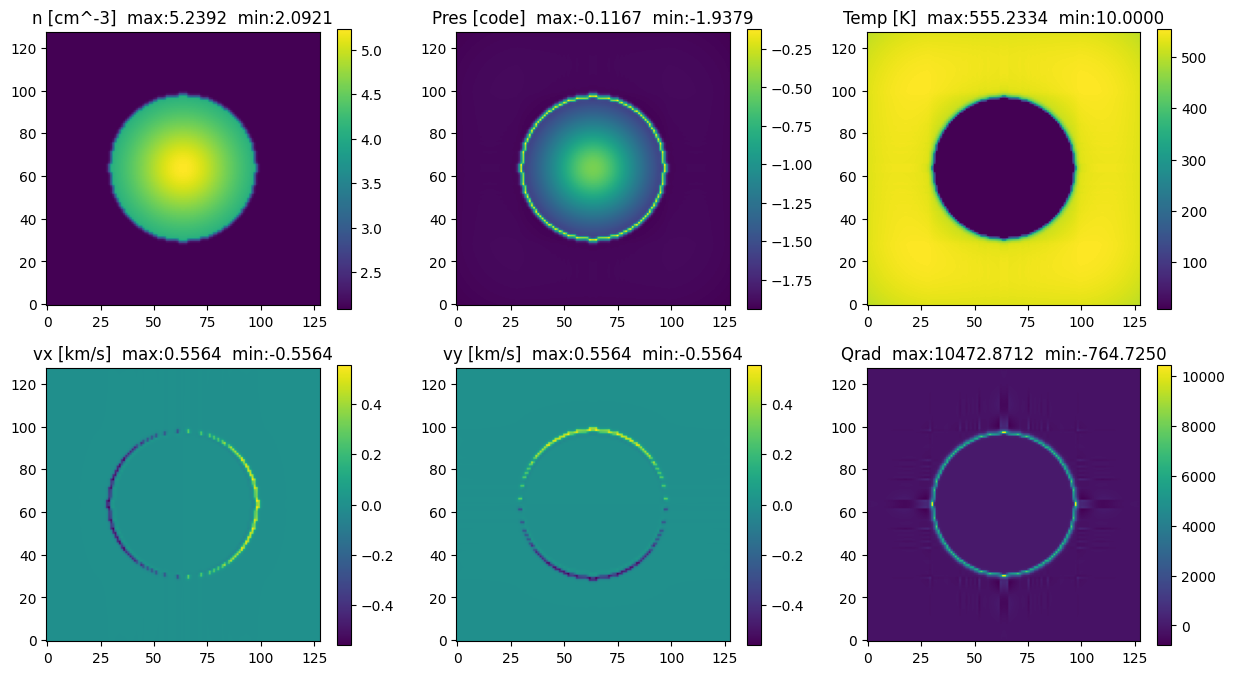

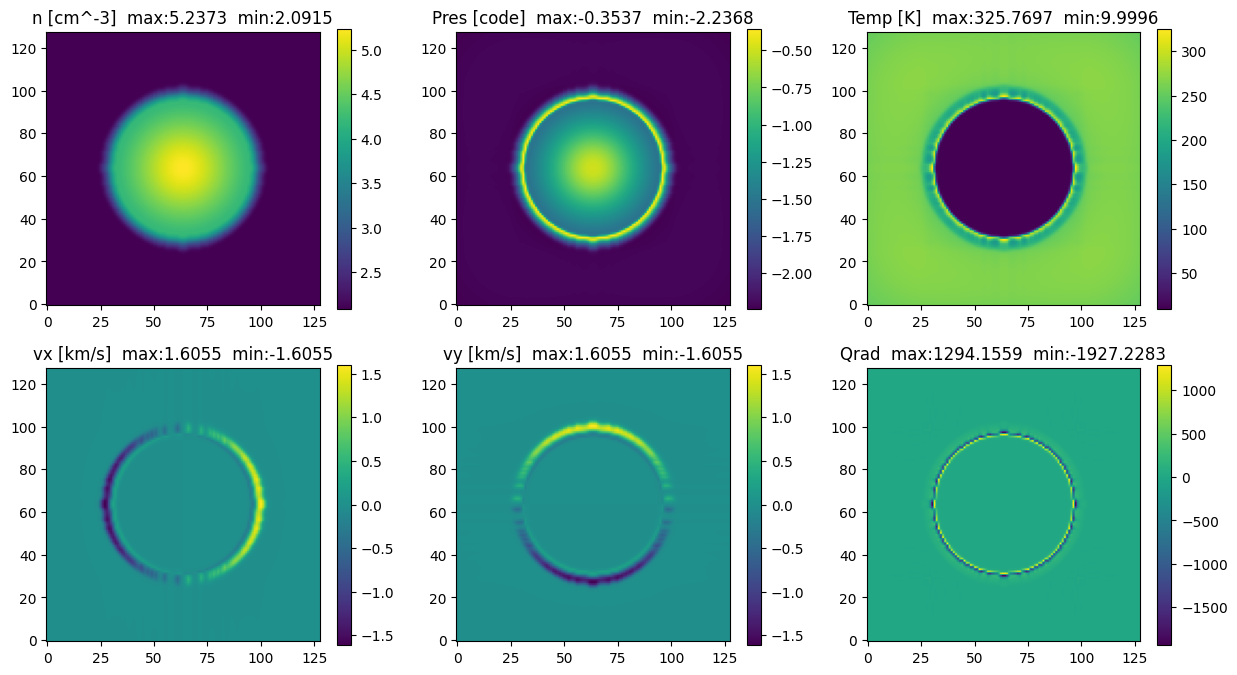

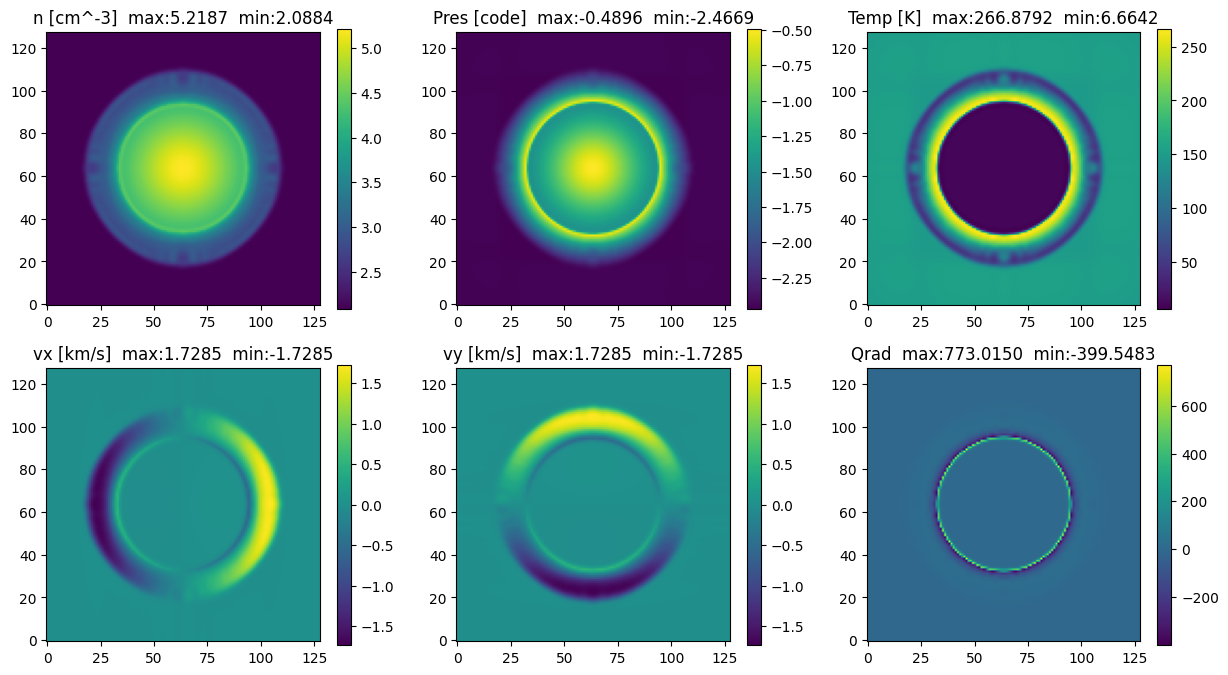

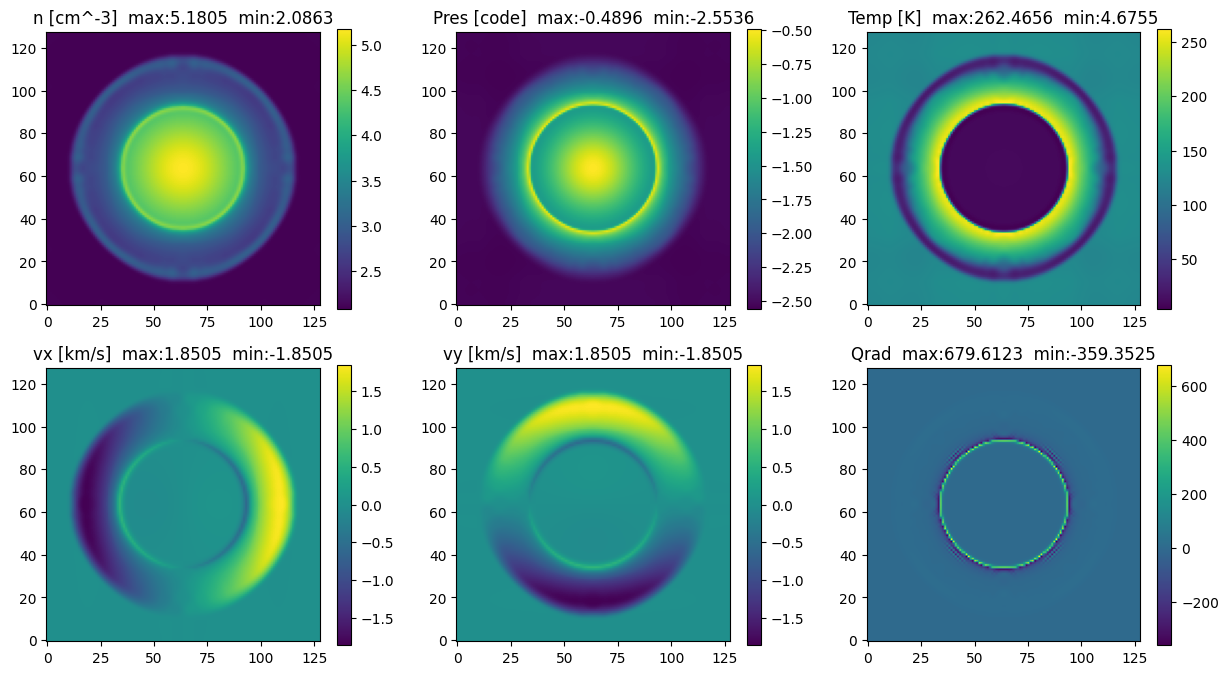

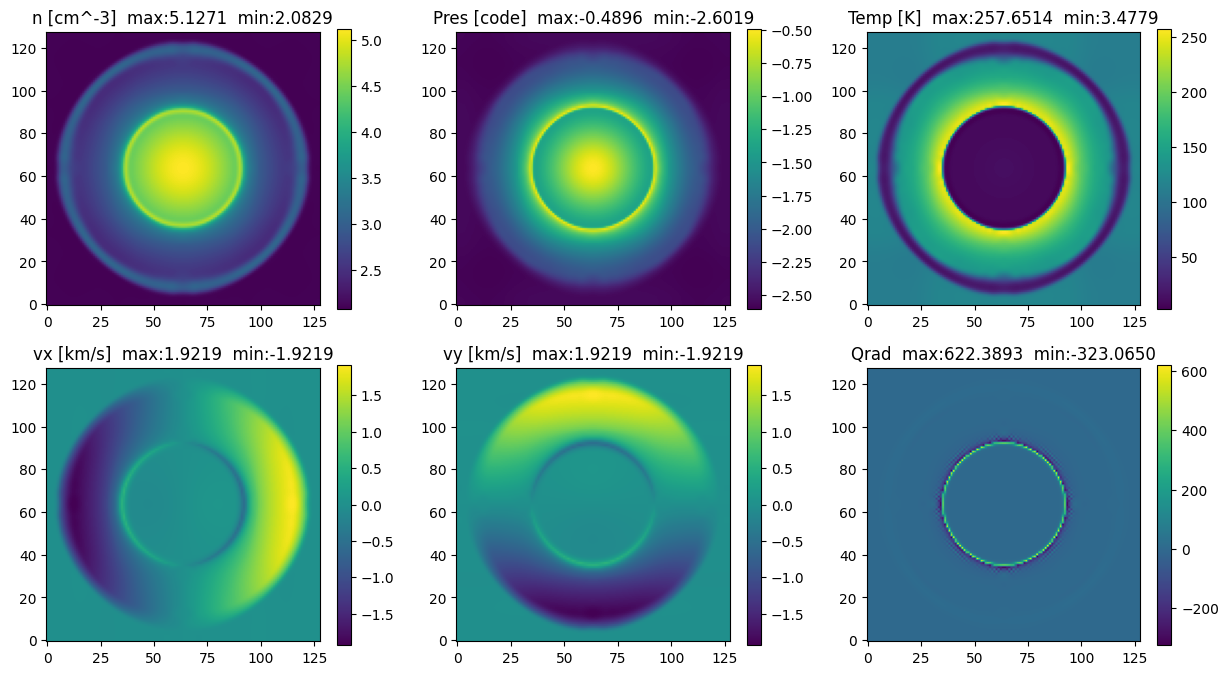

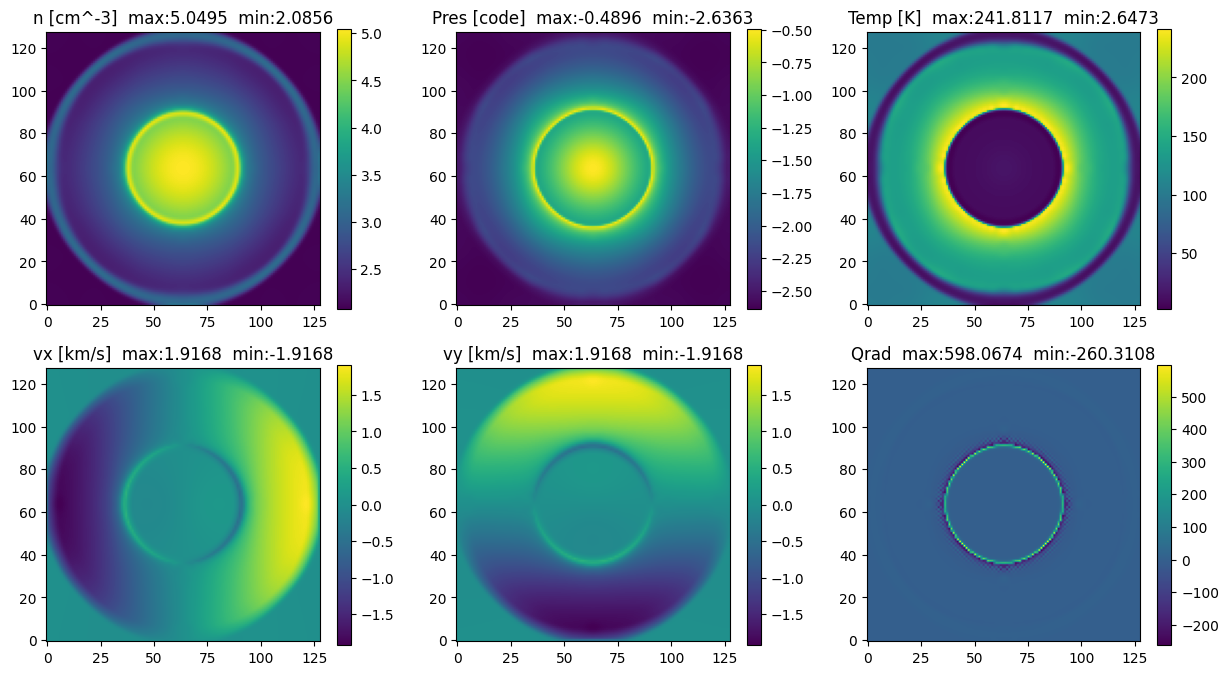

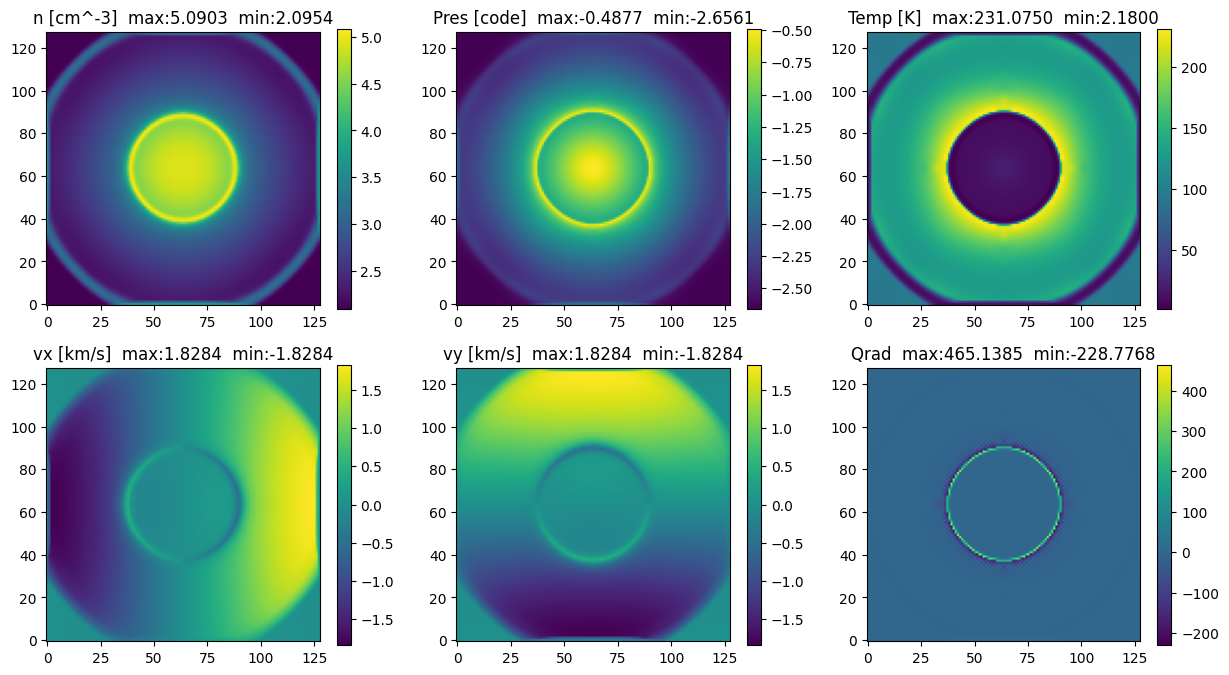

In [25]:
m = u.n[2]//2

for i in range(400):
    Step(u, rt, Crad = Crad, delay_factor = delay_factor)
    u.T = (u.pressure() / u.D) * u.units.T
    
    if u.it % 50 == 0:                                                                     # Print/show every 50 iterations
        print("It, time [yr, code_units], Max/Min Temp: ", \
              u.it, u.t * u.units.t / CGS.yr, u.t, u.T.max(), u.T.min())

        dens = np.log10(u.D[:,:,m]*u.units.D / (CGS.mu*CGS.m_u))
        vx = (u.velocity())[0,:,:,m]*u.units.v/CGS.kms
        vy = (u.velocity())[1,:,:,m]*u.units.v/CGS.kms
        pres = np.log10(u.pressure()[:,:,m])
        temp = u.T[:,:,m]
        imshows([dens,pres,temp,vx,vy,rt.qtot[:,:,m]], title=np.array(['n [cm^-3]','Pres [code]','Temp [K]','vx [km/s]','vy [km/s]','Qrad']));

In [26]:
rr = np.copy(u.r)
vr = np.sum(u.velocity()*u.coords, axis = 0) / rr * u.units.v / CGS.kms
rr *= u.units.l / CGS.AU

msize = 0.3

plt.figure(figsize=(16,15))
plt.subplot(3,2,1); plt.scatter(rr, vr, linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Radial velocity [km/s]');        

plt.subplot(3,2,2); plt.scatter(rr, np.log10(np.maximum(u.pressure(),1e-10)), linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Pressure [code units]');

plt.subplot(3,2,3); plt.scatter(rr, np.log10(np.maximum(u.T*u.units.T,0.01)),linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Temperature [K]');

plt.subplot(3,2,4); plt.scatter(rr, np.log10(u.D*u.units.D/(CGS.mu*CGS.m_u)),linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Number density [cm^-3]');

plt.subplot(3,2,5); plt.scatter(rr, rt.qtot,linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Net heating [code units]'); plt.ylim(0.,rt.qtot.max());

plt.subplot(3,2,6); plt.scatter(rr, -rt.qtot,linewidths=0.02, s=msize)
plt.xlabel('AU'); plt.title('Net cooling [code units]'); plt.ylim(0.,-rt.qtot.min());

##### __Task 3b__

In [27]:
def Step(u, rt, tend = None, Crad = 0.1, delay_factor = 1.):
    # Add half a time step worth of heating / cooling from last timestep
    Qrad = rt.qtot
    u.E += Qrad * (0.5 * u.dt)
    dtold = u.dt

    # Limit timestep based on Qrad and a max 25% change in dt per step
    dtmax = Crad * np.min(u.E / (np.abs(Qrad) + 1e-10))
    dtmax = min(dtold * 1.25, dtmax)
    
    # Take a HD step
    u.solver.Step(u, tend=tend, dtmax=dtmax)
    
    # Add another half a time step worth of heating / cooling from last timestep
    # to make a full RT contribution before recomputing the radiative transfer
    u.E += (u.dt - 0.5 * dtold) * rt.qtot
    qold = np.copy(rt.qtot)

    # Recompute the net heating / cooling rate
    rt.rt_step(u)
    rt.qtot *= delay_factor  # Adjust impact of radiative transfer
    
    # Correct half a time step worth of heating / cooling with new solution
    u.E += 0.5 * u.dt * (rt.qtot - qold)
    
    # ---- Core Temperature Enforcement ----
    x, y, z = np.arange(u.n[0]), np.arange(u.n[1]), np.arange(u.n[2])
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z, indexing='ij')

    # Center and radius of the spherical core
    center = (u.n[0] // 2, u.n[1] // 2, u.n[2] // 2)
    core_radius = 2  # Adjust as needed

    # Compute the distance from the center
    distance_from_center = np.sqrt(
        (x_grid - center[0])**2 +
        (y_grid - center[1])**2 +
        (z_grid - center[2])**2)

    # Create a mask for the core
    core_mask = distance_from_center <= core_radius

    rho_center = u.D[core_mask]  # Get the density at the center

    # Adjust the energy to match the desired core temperature (10 K)
    u.E[core_mask] = (10.0 * (u.gamma - 1) * rho_center)  # Set energy to match 10 K

    # Recalculate the temperature at the center to verify it's 10 K
    u.T[core_mask] = (u.E[core_mask] / (u.gamma - 1)) / u.D[core_mask]  # Ensure core temperature is 10 K


In [28]:
units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2);
u = BE_experiment (units, m_solar=1., n=128, gamma=1.01);

# Use 8 wavelengths to get approximately 2 wavelengths per dex
start = np.log10(.5e-4) # First wavelength bin is at .5 micron
stop = np.log10(2000e-4) # Last wavelength bin is at 2000. micron
waves = np.logspace(start, stop, num = 12, endpoint = True)

rt = RT(n=u.n[0],waves=waves,units=u.units,ds=u.ds,direction=[0,])
u.rt = rt

u.solver = MUSCL(u)

delay_factor = 3e-10
Crad = 0.1
# Initial net heating / cooling rate
rt.rt_step(u)
rt.qtot *= delay_factor                     # Adjust impact of radiative transfer
u.dt = (u.E / np.abs(rt.qtot)).min()*Crad   # Estimate initial time step

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430968858477972, 'Stefan': 0.7666592511149339, 'h_P': 1.1119333906579644e-82, 'k_B': 6.941679235796882e-60, 'c': 299790.0, 'm_u': 8.409250879839114e-58}
BE_sphere: gamma,T_K= 1.01 10.0


It, time [yr, code_units], Max/Min Temp, Core Temp:  50 156.03718717914634 0.0016437028128751198 558.5726665197848 9.999999999999998 10.0
It, time [yr, code_units], Max/Min Temp, Core Temp:  100 1514.2705340934897 0.015951394544723142 325.76962863564813 9.999557747188518 10.0
It, time [yr, code_units], Max/Min Temp, Core Temp:  150 7485.607641963259 0.07885373070105489 266.87924845482905 6.49937063457268 10.0
It, time [yr, code_units], Max/Min Temp, Core Temp:  200 13968.32897561981 0.14714301150552778 262.46561861323704 4.297914263671258 10.000000000000002
It, time [yr, code_units], Max/Min Temp, Core Temp:  250 20279.37271395512 0.2136238327277782 257.6515109937483 3.2072764785700967 10.0
It, time [yr, code_units], Max/Min Temp, Core Temp:  300 27392.41054443147 0.2885528961222487 241.8118785541584 2.5190174692526917 10.0
It, time [yr, code_units], Max/Min Temp, Core Temp:  350 35743.5124200158 0.3765237823683908 231.0751370049634 2.058405615306262 10.0
It, time [yr, code_units], Max

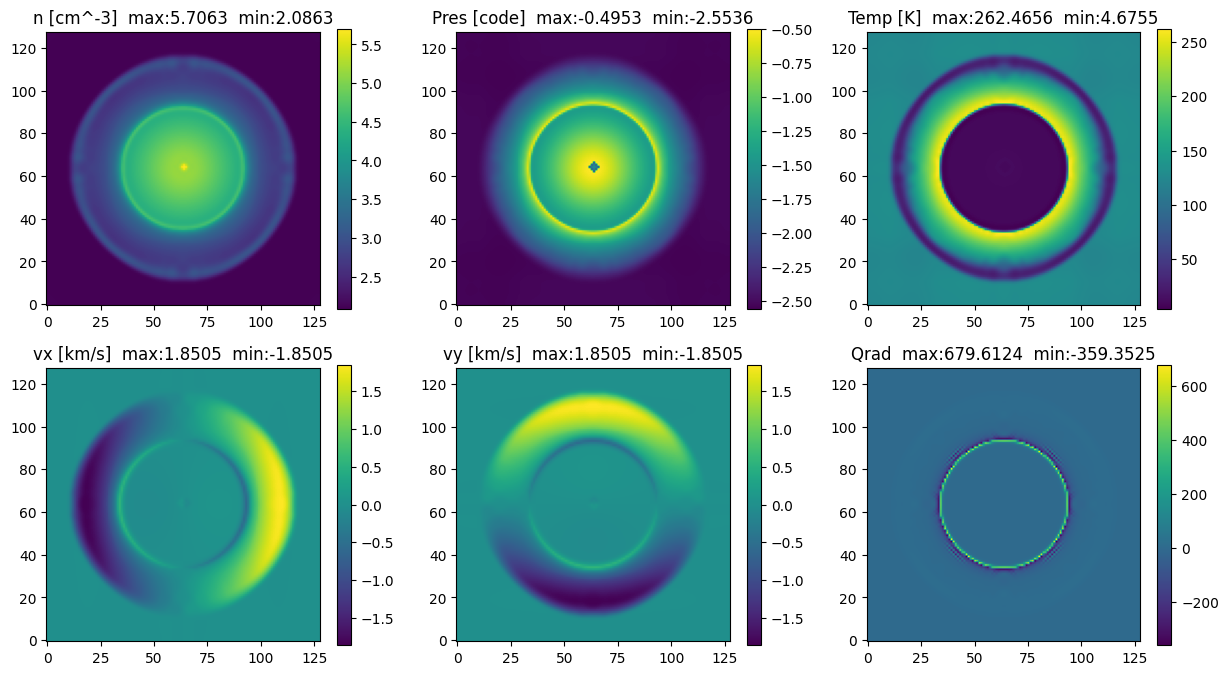

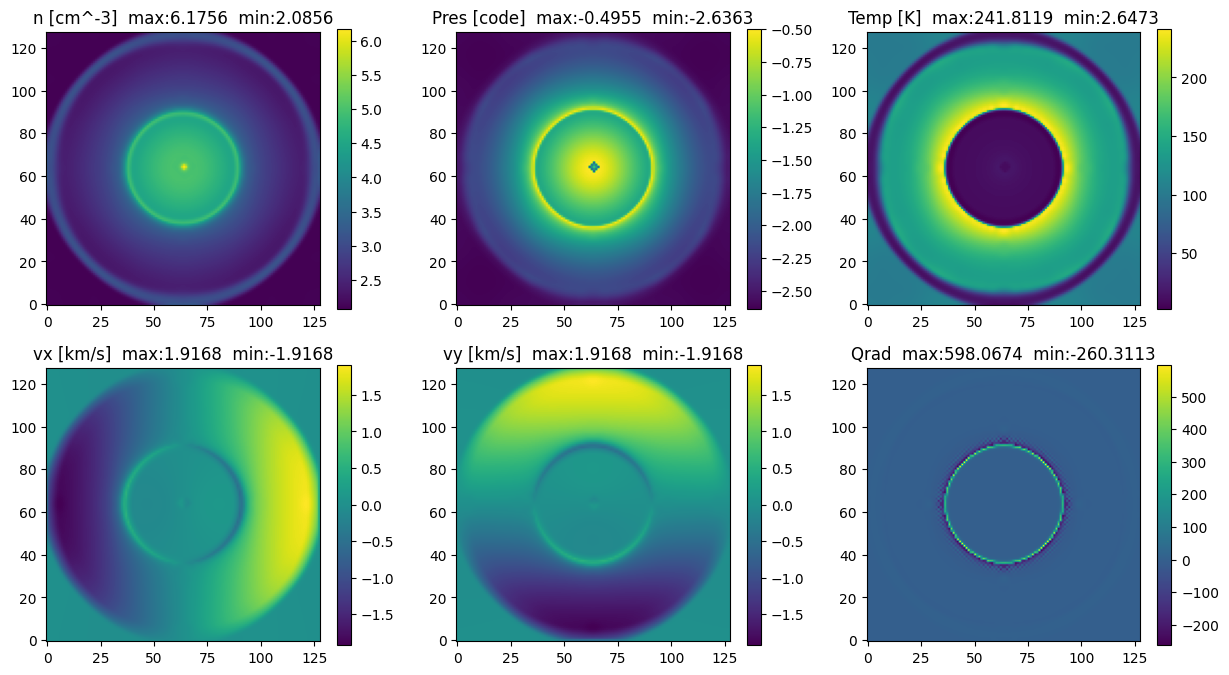

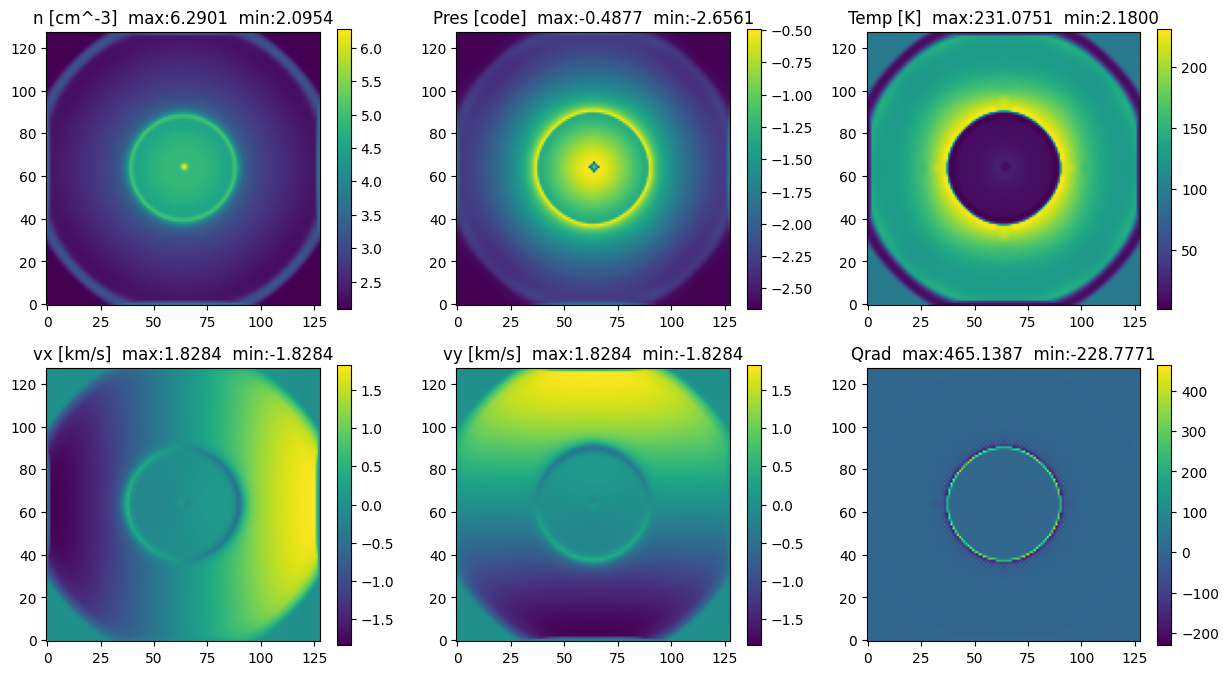

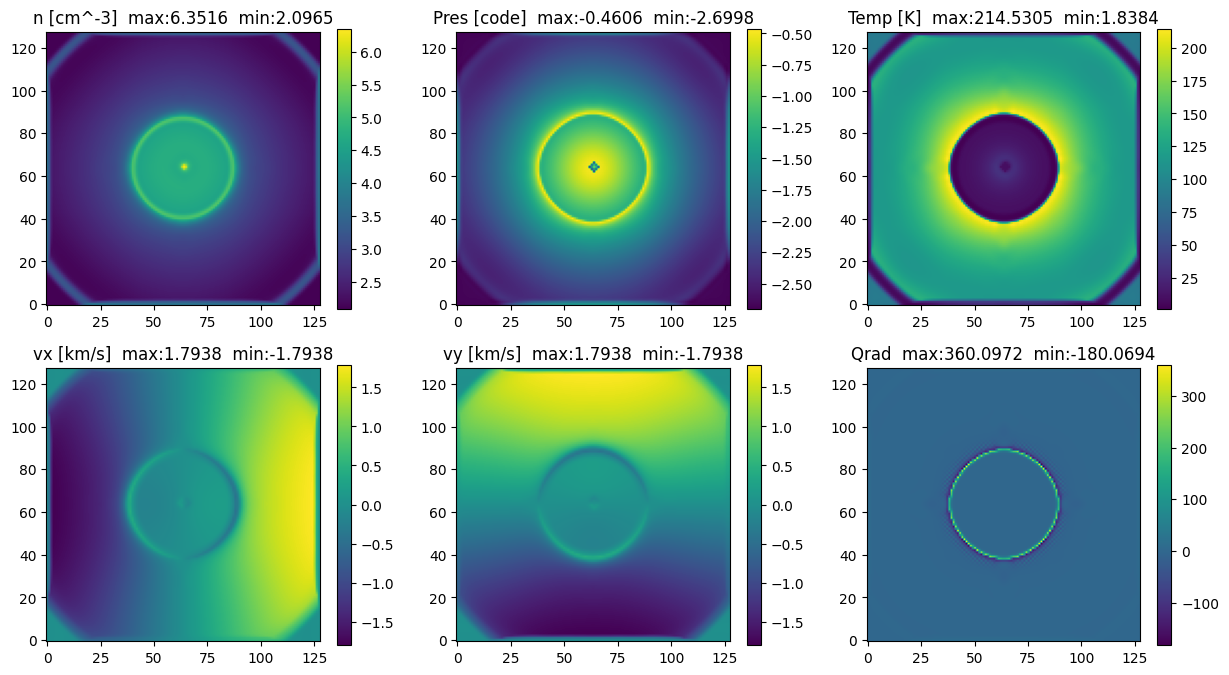

In [29]:
m = u.n[2]//2

for i in range(400):
    Step(u, rt, Crad=Crad, delay_factor = delay_factor)
    u.T = (u.pressure() / u.D) * u.units.T

    # Enforce the core temperature to be 10 K (after updating)
    x, y, z = np.arange(u.n[0]), np.arange(u.n[1]), np.arange(u.n[2])
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z, indexing='ij')

    center = (u.n[0] // 2, u.n[1] // 2, u.n[2] // 2)
    core_radius = 2  # Adjust as needed

    distance_from_center = np.sqrt(
        (x_grid - center[0])**2 +
        (y_grid - center[1])**2 +
        (z_grid - center[2])**2)

    core_mask = distance_from_center <= core_radius

    rho_center = u.D[core_mask]                                                              # Get the density at the center
    u.E[core_mask] = (10.0 * (u.gamma - 1) * rho_center)                                     # Adjust energy to match 10 K
    u.T[core_mask] = (u.E[core_mask] / (u.gamma - 1)) / u.D[core_mask]                       # Recalculate the temperature at the core

    if u.it % 50 == 0:                                                                     
        print("It, time [yr, code_units], Max/Min Temp, Core Temp: ", \
              u.it, u.t * u.units.t / CGS.yr, u.t, u.T.max(), u.T.min(), u.T[u.n[0]//2, u.n[1]//2, u.n[2]//2])

        dens = np.log10(u.D[:,:,m]*u.units.D / (CGS.mu*CGS.m_u))
        vx = (u.velocity())[0,:,:,m]*u.units.v/CGS.kms
        vy = (u.velocity())[1,:,:,m]*u.units.v/CGS.kms
        pres = np.log10(u.pressure()[:,:,m])
        temp = u.T[:,:,m]
        imshows([dens, pres, temp, vx, vy, rt.qtot[:,:,m]], title=np.array(['n [cm^-3]', 'Pres [code]', 'Temp [K]', 'vx [km/s]', 'vy [km/s]', 'Qrad']))